In [2]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel
import gc

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
import string

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [3]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.plotting import plot_tsne_colors, plot_label_tags
from text_embeddings_src.scalebars import add_scalebar_frac

In [4]:
import jupyter_black

jupyter_black.load(line_length=79)

In [7]:
variables_path = Path("../../results/variables")
figures_path = Path("../../results/figures/updated_dataset/final_figures")
data_path = Path("../../data")
# berenslab_data_path = Path("/gpfs01/berens/data/data/GPT_wiki_intro")

In [8]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
import text_embeddings_src

nb_path = Path(text_embeddings_src.__path__[0]).parents[0] / Path(
    "scripts/updated_dataset"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [9]:
plt.style.use((nb_path / Path("../matplotlib_style.txt")).resolve(strict=True))

In [10]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers,openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-10-01 21:11:30CEST

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

transformers: 4.43.4
openTSNE    : 1.0.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

memory_profiler    : 0.61.0
torch              : 2.1.1
pandas             : 2.1.3
jupyter_black      : 0.3.4
scipy              : 1.11.4
numpy              : 1.26.2
text_embeddings_src: 0.0.0
matplotlib         : 3.8.2
distro             : 1.8.0

Watermark: 2.4.3

Ubuntu 22.04.3 LTS


# Import

In [7]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    # index=False,
    engine="pyarrow",
    # compression="gzip",
)

CPU times: user 304 ms, sys: 118 ms, total: 422 ms
Wall time: 763 ms


In [8]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [9]:
iclr2024

index  year          id  \
0          0  2017   S1VaB4cex   
1          1  2017   H1W1UN9gg   
2          2  2017   r1GKzP5xx   
3          3  2017   S1J0E-71l   
4          4  2017   SJGCiw5gl   
...      ...   ...         ...   
24342   7299  2024  1bbPQShCT2   
24343   7300  2024  Ny150AblPu   
24344   7301  2024  ZGBOfAQrMl   
24345   7302  2024  J2kRjUAOLh   
24346   7303  2024  U0P622bfUN   

                                                   title  \
0      FractalNet: Ultra-Deep Neural Networks without...   
1                           Deep Information Propagation   
2                    Recurrent Normalization Propagation   
3        Surprisal-Driven Feedback in Recurrent Networks   
4      Pruning Convolutional Neural Networks for Reso...   
...                                                  ...   
24342            I-PHYRE: Interactive Physical Reasoning   
24343  EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...   
24344  Video Super-Resolution Transformer with Masked...   
24345  Contrastive Predict-and-Search for Mixed Integ...   
24346  Federated Generative Learning with Foundation ...   

                                                abstract  \
0      We introduce a design strategy for neural netw...   
1      We study the behavior of untrained neural netw...   
2      We propose a LSTM parametrization  that preser...   
3      Recurrent neural nets are widely used for pred...   
4      We propose a new formulation for pruning convo...   
...                                                  ...   
24342  Current evaluation protocols predominantly ass...   
24343  In the battle against widespread online misinf...   
24344  Recently, Vision Transformer has achieved grea...   
24345  Mixed integer linear programs  (MILP) are flex...   
24346  Existing federated learning solutions focus on...   

                                                 authors  \
0      Gustav Larsson, Michael Maire, Gregory Shakhna...   
1      Samuel S. Schoenholz, Justin Gilmer, Surya Gan...   
2          César Laurent, Nicolas Ballas, Pascal Vincent   
3                        K, a, m, i, l,  , R, o, c, k, i   
4      Pavlo Molchanov, Stephen Tyree, Tero Karras, T...   
...                                                  ...   
24342                                                      
24343                                                      
24344                                                      
24345                                                      
24346                                                      

                       decision        scores  \
0               Accept (Poster)  [5, 7, 6, 6]   
1               Accept (Poster)     [8, 9, 8]   
2      Invite to Workshop Track     [4, 6, 6]   
3                        Reject     [3, 4, 3]   
4               Accept (Poster)     [6, 7, 9]   
...                         ...           ...   
24342                                      []   
24343                                      []   
24344                                      []   
24345                                      []   
24346                                      []   

                                                keywords gender-first  \
0                                                     []         male   
1                                [theory, deep learning]         male   
2                          [deep learning, optimization]         None   
3      [unsupervised learning, applications, deep lea...         None   
4                     [deep learning, transfer learning]         None   
...                                                  ...          ...   
24342            [intuitive physics, physical reasoning]         None   
24343            [mis-contextualization, media forensic]         None   
24344  [video super-resolution, adaptive, memory and ...         None   
24345     [mixed integer programs; contrastive learning]         None   
24346                 [federated learning, 

# Figure 1

## Import

In [11]:
# labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr_2.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color_2.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

## Plot

In [12]:
selected_labels_dict = dict()
selected_labels_dict["adversarial"] = dict_label_to_color["adversarial"]
selected_labels_dict["federated learning"] = dict_label_to_color[
    "federated learning"
]
selected_labels_dict["neural architecture search"] = dict_label_to_color[
    "neural architecture search"
]
selected_labels_dict["optimization"] = dict_label_to_color["optimization"]
selected_labels_dict["RNNs"] = dict_label_to_color["RNNs"]
selected_labels_dict["RL"] = dict_label_to_color["RL"]
selected_labels_dict["offline RL"] = dict_label_to_color["offline RL"]
selected_labels_dict["continual learning"] = dict_label_to_color[
    "continual learning"
]
# selected_labels_dict["pruning"] = dict_label_to_color["pruning"]
#
selected_labels_dict["fairness"] = dict_label_to_color["fairness"]
selected_labels_dict["graphs"] = dict_label_to_color["graphs"]
selected_labels_dict["out-of-distribution"] = dict_label_to_color[
    "out-of-distribution"
]
selected_labels_dict["transfer learning"] = dict_label_to_color[
    "transfer learning"
]
selected_labels_dict["GANs"] = dict_label_to_color["GANs"]
selected_labels_dict["autoencoders"] = dict_label_to_color["autoencoders"]
selected_labels_dict["diffusion models"] = dict_label_to_color[
    "diffusion models"
]
selected_labels_dict["ViTs"] = dict_label_to_color["ViTs"]
selected_labels_dict["transformers"] = dict_label_to_color["transformers"]
selected_labels_dict["language models"] = dict_label_to_color[
    "language models"
]
selected_labels_dict["LLMs"] = dict_label_to_color["LLMs"]
# selected_labels_dict["causality"] = dict_label_to_color["causality"]

In [13]:
mpl.rcParams["xtick.labelsize"] = 6
mpl.rcParams["ytick.labelsize"] = 6
mpl.rcParams["axes.labelsize"] = 6
# mpl.rcParams["axes.titlesize"] = 6

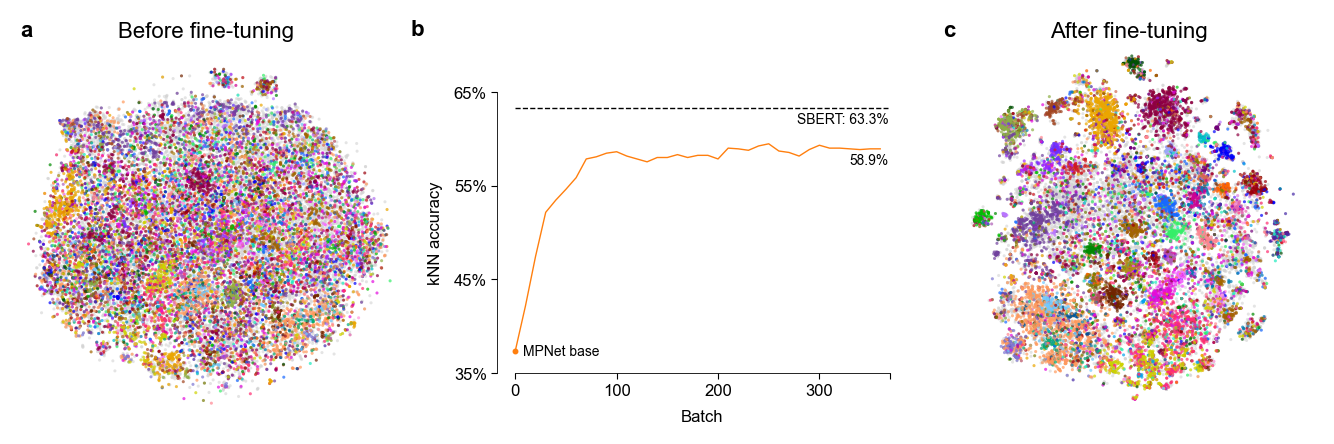

In [84]:
# %matplotlib inline
# from matplotlib import ticker

# model_name = "MPNet"

# fig, axs = plt.subplots(
#     1,
#     3,
#     figsize=(6.75, 2.1),
#     dpi=200,  # width_ratios=[0.3, 0.4, 0.3]
#     layout="constrained",
# )
# txtkwargs = dict(size=8, weight="bold", va="top", ha="left")
# titlekwargs = dict(size=8, va="top", ha="center")

# saving_path = Path("embeddings_" + model_name.lower()) / Path(
#     "updated_dataset"
# )
# ## (a)
# # load
# tsne_av = np.load(variables_path / saving_path / "tsne_av.npy")
# # plot
# xlim = (-75, 75)
# ylim = (-75, 75)
# plot_tsne_colors(
#     tsne_av,
#     colors_iclr,
#     ax=axs[0],
#     x_lim=xlim,
#     y_lim=ylim,
# )
# axs[0].text(
#     0.5, 1.07, "Before fine-tuning", transform=axs[0].transAxes, **titlekwargs
# )
# # add_scalebar_frac(axs[0])
# axs[0].text(
#     0, 1.07, string.ascii_lowercase[0], transform=axs[0].transAxes, **txtkwargs
# )


# ## (b)
# # load
# saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
# knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

# saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
# knn_acc_highd_sbert = np.load(
#     variables_path / "updated_dataset" / saving_name_2
# )
# knn_accuracies_iclr = np.load(
#     variables_path
#     / saving_path
#     / "knn_accuracies_batches_train_iclr_eval_iclr_v1.npy",
# )
# # plot
# axs[1].set_aspect((370 / 0.3) * (3 / 4))
# axs[1].plot(
#     np.arange(37) * 10,
#     np.vstack(knn_accuracies_iclr)[:, 0],
#     label="ICLR",
#     c="tab:orange",
# )
# axs[1].text(
#     368,
#     np.vstack(knn_accuracies_iclr)[:, 0][-1] - 0.005,
#     f"{np.vstack(knn_accuracies_iclr)[:, 0][-1]:.1%}",
#     fontsize=5,
#     va="top",
#     ha="right",
# )
# axs[1].hlines(knn_acc_highd_sbert[0], 0, 368, color="k", linestyles="--")
# axs[1].text(
#     368,
#     knn_acc_highd_sbert[0] - 0.005,
#     f"SBERT: {knn_acc_highd_sbert[0]:.1%}",
#     fontsize=5,
#     va="top",
#     ha="right",
# )
# axs[1].scatter(0, knn_acc_highd[0], c="tab:orange", s=5)
# axs[1].text(
#     8,
#     knn_acc_highd[0],
#     f"MPNet base",
#     fontsize=5,
#     va="center",
#     ha="left",
# )
# axs[1].set_ylim(0.35, 0.65)
# axs[1].set_yticks(np.arange(0.35, 0.75, 0.1))
# axs[1].set_xticks([0, 100, 200, 300, 370])
# axs[1].set_xticklabels([0, 100, 200, 300, ""])
# axs[1].set_xlabel("Batch")
# axs[1].set_ylabel("kNN accuracy")
# axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
# axs[1].spines.bottom.set_bounds(0, 370)
# # letter and title
# axs1_title = fig.add_axes(
#     [
#         0.013157849166890997 + 0.29643807395702737,
#         0.041831176849881024,
#         0.31040710562414286 + 0.05106986562779636,
#         0.8801662437850396,
#     ]
# )  # left, bottom, width, height
# # axs1_title.text(
# #     0.5, 1.07, "kNN accuracy", transform=axs1_title.transAxes, **titlekwargs
# # )
# axs1_title.text(
#     0,
#     1.07,
#     string.ascii_lowercase[1],
#     transform=axs1_title.transAxes,
#     **txtkwargs,
# )
# axs1_title.axis("off")


# ## (c)
# # load
# xlim = (-95, 95)
# ylim = (-95, 95)
# tsne_av_after = np.load(
#     variables_path
#     / saving_path
#     / "tsne_abstracts_only_av_after_training_av_1_epoch.npy",
# )
# plot_tsne_colors(
#     tsne_av_after,
#     colors_iclr,
#     ax=axs[2],
#     x_lim=xlim,
#     y_lim=ylim,
# )
# axs[2].text(
#     0.5, 1.07, "After fine-tuning", transform=axs[2].transAxes, **titlekwargs
# )
# # add_scalebar_frac(axs[2])
# axs[2].text(
#     0, 1.07, string.ascii_lowercase[2], transform=axs[2].transAxes, **txtkwargs
# )

# fig.savefig(figures_path / "fig1_v5.png")
# fig.savefig(figures_path / "fig1_v5.pdf")

/gpfs01/berens/user/rgonzalesmarquez/phd/text-embeddings/text_embeddings_src/plotting.py:351: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot([x[i],center_cluster_coordinates_right.x[i]],[y[i],center_cluster_coordinates_right.y[i]], c=colr, linewidth=0.4, clip_on=False)


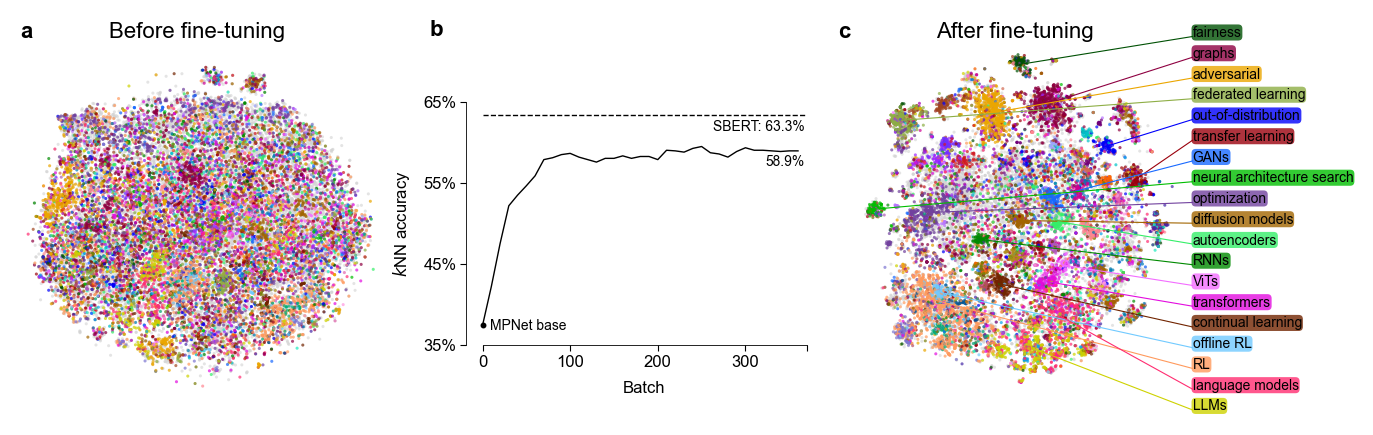

In [84]:
%matplotlib inline
from matplotlib import ticker

model_name = "MPNet"

fig, axs = plt.subplots(
    1,
    3,
    figsize=(6.75, 2.1),
    dpi=200,
    # width_ratios=[0.3, 0.3, 0.4],
    layout="constrained",
)
txtkwargs = dict(size=8, weight="bold", va="top", ha="left")
titlekwargs = dict(size=8, va="top", ha="center")

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
## (a)
# load
tsne_av = np.load(variables_path / saving_path / "tsne_av.npy")
# plot
xlim = (-75, 75)
ylim = (-75, 75)
plot_tsne_colors(
    tsne_av,
    colors_iclr,
    ax=axs[0],
    x_lim=xlim,
    y_lim=ylim,
)
axs[0].text(
    0.5, 1.07, "Before fine-tuning", transform=axs[0].transAxes, **titlekwargs
)
# add_scalebar_frac(axs[0])
axs[0].text(
    0, 1.07, string.ascii_lowercase[0], transform=axs[0].transAxes, **txtkwargs
)


## (b)
# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_eval_iclr_v1.npy",
)
# plot
axs[1].set_aspect((370 / 0.3) * (3 / 4))
axs[1].plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0],
    label="ICLR",
    c="k",
)
axs[1].text(
    368,
    np.vstack(knn_accuracies_iclr)[:, 0][-1] - 0.005,
    f"{np.vstack(knn_accuracies_iclr)[:, 0][-1]:.1%}",
    fontsize=5,
    va="top",
    ha="right",
)
axs[1].hlines(knn_acc_highd_sbert[0], 0, 368, color="k", linestyles="--")
axs[1].text(
    368,
    knn_acc_highd_sbert[0] - 0.005,
    f"SBERT: {knn_acc_highd_sbert[0]:.1%}",
    fontsize=5,
    va="top",
    ha="right",
)
axs[1].scatter(0, knn_acc_highd[0], c="k", s=5)
axs[1].text(
    8,
    knn_acc_highd[0],
    f"MPNet base",
    fontsize=5,
    va="center",
    ha="left",
)
axs[1].set_ylim(0.35, 0.65)
axs[1].set_yticks(np.arange(0.35, 0.75, 0.1))
axs[1].set_xticks([0, 100, 200, 300, 370])
axs[1].set_xticklabels([0, 100, 200, 300, ""])
axs[1].set_xlabel("Batch")
axs[1].set_ylabel("$k$NN accuracy")
axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs[1].spines.bottom.set_bounds(0, 370)
# letter and title
axs1_title = fig.add_axes(
    [
        0.013157849166890997 + 0.29643807395702737,
        0.041831176849881024,
        0.31040710562414286 + 0.05106986562779636,
        0.8801662437850396,
    ]
)  # left, bottom, width, height
# axs1_title.text(
#     0.5, 1.07, "kNN accuracy", transform=axs1_title.transAxes, **titlekwargs
# )
axs1_title.text(
    0,
    1.07,
    string.ascii_lowercase[1],
    transform=axs1_title.transAxes,
    **txtkwargs,
)
axs1_title.axis("off")


## (c)
# load
xlim = (-95, 95)
ylim = (-95, 95)
tsne_av_after = np.load(
    variables_path
    / saving_path
    / "tsne_abstracts_only_av_after_training_av_1_epoch.npy",
)
plot_tsne_colors(
    tsne_av_after,
    colors_iclr,
    ax=axs[2],
    x_lim=xlim,
    y_lim=ylim,
)
plot_label_tags(
    tsne_av_after,
    colors_iclr,
    selected_labels_dict,
    x_lim=xlim,
    y_lim=(-100, 100),  # (-70, 70)
    ax=axs[2],
    subset=False,
    fontsize=5,
    capitalize=False,
    middle_value=-90,  # 5
)
axs[2].text(
    0.5, 1.07, "After fine-tuning", transform=axs[2].transAxes, **titlekwargs
)
# add_scalebar_frac(axs[2])
axs[2].text(
    0, 1.07, string.ascii_lowercase[2], transform=axs[2].transAxes, **txtkwargs
)

fig.savefig(figures_path / "fig1_v10.png")
fig.savefig(figures_path / "fig1_v10.pdf")

### Poster

/gpfs01/berens/user/rgonzalesmarquez/phd/text-embeddings/text_embeddings_src/plotting.py:335: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot([x[i],center_cluster_coordinates_left.x[i]],[y[i],center_cluster_coordinates_left.y[i]], c=colr, linewidth=0.4, clip_on=False)
/gpfs01/berens/user/rgonzalesmarquez/phd/text-embeddings/text_embeddings_src/plotting.py:351: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot([x[i],center_cluster_coordinates_right.x[i]],[y[i],center_cluster_coordinates_right.y[i]], c=colr, linewidth=0.4, clip_on=False)


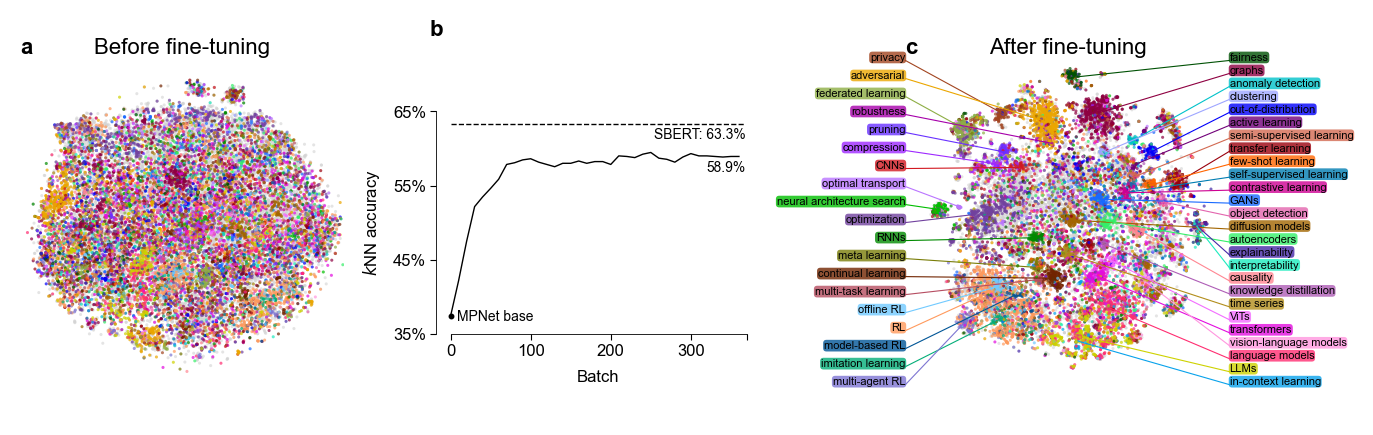

In [19]:
%matplotlib inline
from matplotlib import ticker

model_name = "MPNet"

fig, axs = plt.subplots(
    1,
    3,
    figsize=(6.75, 2.1),
    dpi=200,
    # width_ratios=[0.3, 0.3, 0.4],
    layout="constrained",
)
txtkwargs = dict(size=8, weight="bold", va="top", ha="left")
titlekwargs = dict(size=8, va="top", ha="center")

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
## (a)
# load
tsne_av = np.load(variables_path / saving_path / "tsne_av.npy")
# plot
xlim = (-75, 75)
ylim = (-75, 75)
plot_tsne_colors(
    tsne_av,
    colors_iclr,
    ax=axs[0],
    x_lim=xlim,
    y_lim=ylim,
)
axs[0].text(
    0.5, 1.07, "Before fine-tuning", transform=axs[0].transAxes, **titlekwargs
)
# add_scalebar_frac(axs[0])
axs[0].text(
    0, 1.07, string.ascii_lowercase[0], transform=axs[0].transAxes, **txtkwargs
)


## (b)
# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_eval_iclr_v1.npy",
)
# plot
axs[1].set_aspect((370 / 0.3) * (3 / 4))
axs[1].plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0],
    label="ICLR",
    c="k",
)
axs[1].text(
    368,
    np.vstack(knn_accuracies_iclr)[:, 0][-1] - 0.005,
    f"{np.vstack(knn_accuracies_iclr)[:, 0][-1]:.1%}",
    fontsize=5,
    va="top",
    ha="right",
)
axs[1].hlines(knn_acc_highd_sbert[0], 0, 368, color="k", linestyles="--")
axs[1].text(
    368,
    knn_acc_highd_sbert[0] - 0.005,
    f"SBERT: {knn_acc_highd_sbert[0]:.1%}",
    fontsize=5,
    va="top",
    ha="right",
)
axs[1].scatter(0, knn_acc_highd[0], c="k", s=5)
axs[1].text(
    8,
    knn_acc_highd[0],
    f"MPNet base",
    fontsize=5,
    va="center",
    ha="left",
)
axs[1].set_ylim(0.35, 0.65)
axs[1].set_yticks(np.arange(0.35, 0.75, 0.1))
axs[1].set_xticks([0, 100, 200, 300, 370])
axs[1].set_xticklabels([0, 100, 200, 300, ""])
axs[1].set_xlabel("Batch")
axs[1].set_ylabel("$k$NN accuracy")
axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs[1].spines.bottom.set_bounds(0, 370)
# letter and title
axs1_title = fig.add_axes(
    [
        0.013157849166890997 + 0.29643807395702737,
        0.041831176849881024,
        0.31040710562414286 + 0.05106986562779636,
        0.8801662437850396,
    ]
)  # left, bottom, width, height
# axs1_title.text(
#     0.5, 1.07, "kNN accuracy", transform=axs1_title.transAxes, **titlekwargs
# )
axs1_title.text(
    0,
    1.07,
    string.ascii_lowercase[1],
    transform=axs1_title.transAxes,
    **txtkwargs,
)
axs1_title.axis("off")


## (c)
# load
xlim = (-95, 95)
ylim = (-95, 95)
tsne_av_after = np.load(
    variables_path
    / saving_path
    / "tsne_abstracts_only_av_after_training_av_1_epoch.npy",
)
plot_tsne_colors(
    tsne_av_after,
    colors_iclr,
    ax=axs[2],
    x_lim=xlim,
    y_lim=ylim,
)
# plot_label_tags(
#     tsne_av_after,
#     colors_iclr,
#     selected_labels_dict,
#     x_lim=xlim,
#     y_lim=(-100, 100),  # (-70, 70)
#     ax=axs[2],
#     subset=False,
#     fontsize=5,
#     capitalize=False,
#     middle_value=-90,  # 5
# )
plot_label_tags(
    tsne_av_after,
    colors_iclr,
    dict_label_to_color,
    x_lim=xlim,
    y_lim=ylim,
    ax=axs[2],
    subset=False,
    fontsize=4,
    capitalize=False,
)
axs[2].text(
    0.5, 1.07, "After fine-tuning", transform=axs[2].transAxes, **titlekwargs
)
# add_scalebar_frac(axs[2])
axs[2].text(
    0, 1.07, string.ascii_lowercase[2], transform=axs[2].transAxes, **txtkwargs
)

# fig.savefig(figures_path / "fig1_poster_v3.png", dpi=700)
fig.savefig(figures_path / "fig1_poster_v5.pdf", dpi=1500)

/gpfs01/berens/user/rgonzalesmarquez/phd/text-embeddings/text_embeddings_src/plotting.py:329: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot([x[i],center_cluster_coordinates_left.x[i]],[y[i],center_cluster_coordinates_left.y[i]], c=colr, linewidth=0.4, clip_on=False)
/gpfs01/berens/user/rgonzalesmarquez/phd/text-embeddings/text_embeddings_src/plotting.py:345: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot([x[i],center_cluster_coordinates_right.x[i]],[y[i],center_cluster_coordinates_right.y[i]], c=colr, linewidth=0.4, clip_on=False)


Text(0.5, 1.0, 'SVD (d=100)')

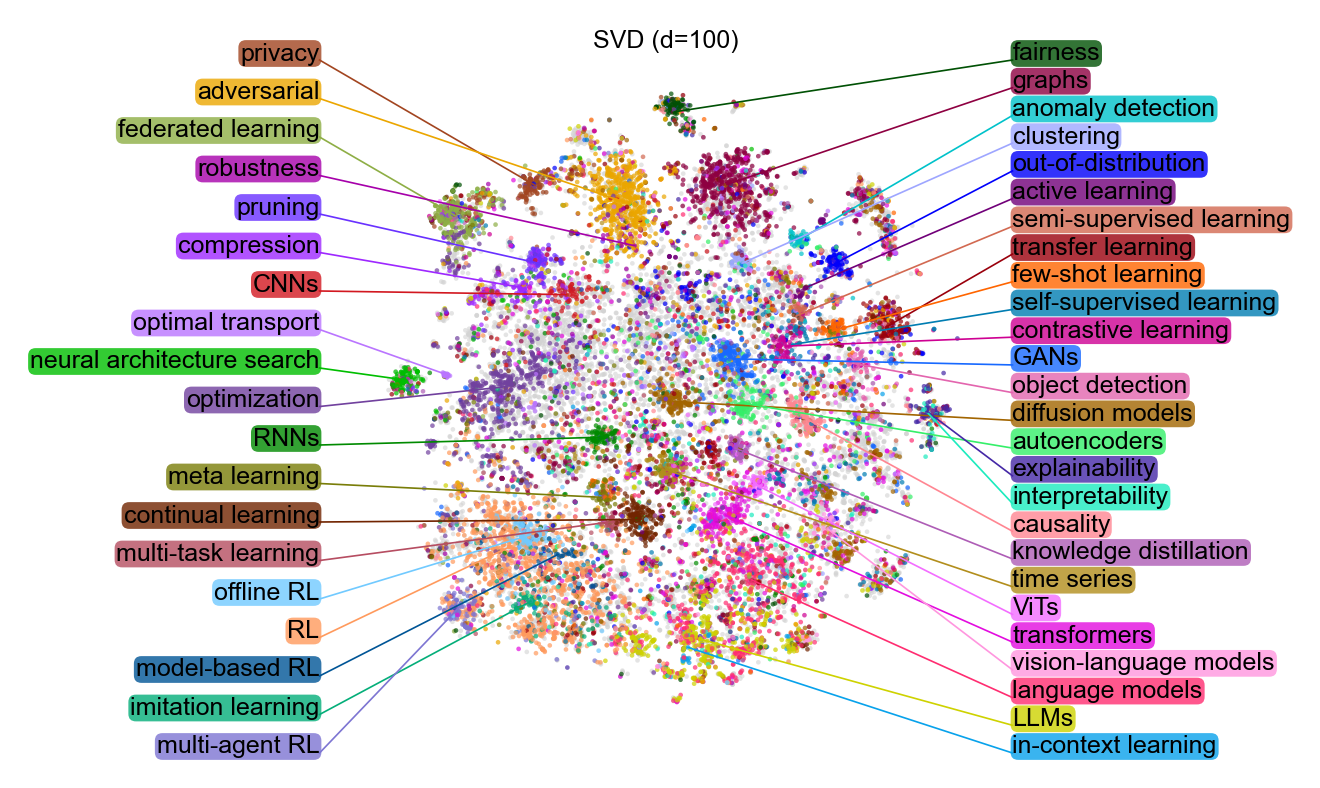

In [141]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
xlim = (-100, 100)
ylim = (-100, 100)
tsne_svd = np.load(variables_path / "updated_dataset" / "tsne_svd.npy")
plot_tsne_colors(tsne_av_after, colors_iclr, ax=ax, x_lim=xlim, y_lim=ylim)
plot_label_tags(
    tsne_av_after,
    colors_iclr,
    dict_label_to_color,
    x_lim=xlim,
    y_lim=ylim,
    ax=ax,
    subset=False,
    fontsize=6,
    capitalize=False,
)
ax.set_title("SVD (d=100)")
# fig.savefig(figures_path / "tsne_iclr_svd_with_tags_v5.png")

### One-column

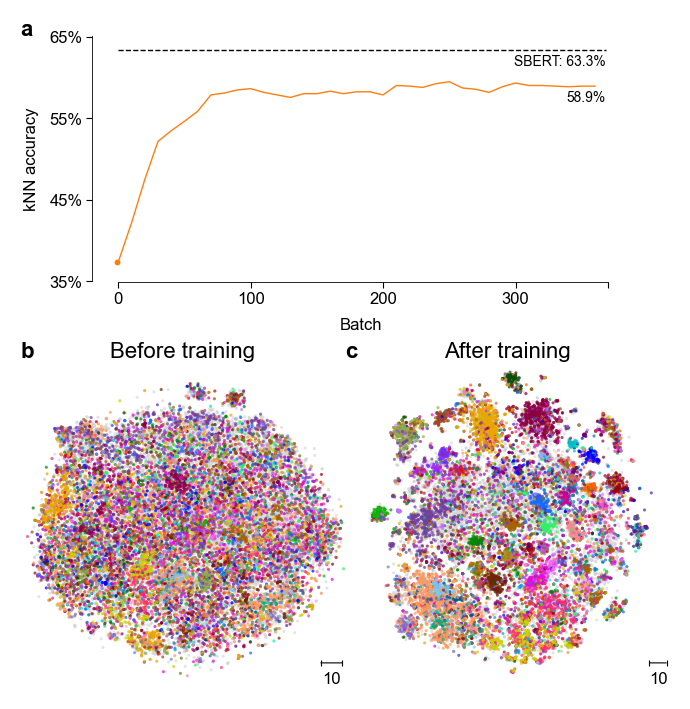

In [43]:
%matplotlib inline
from matplotlib import ticker

model_name = "MPNet"

fig = plt.figure(
    figsize=(3.25, 3.5),
    dpi=200,
)
txtkwargs = dict(size=8, weight="bold", va="top", ha="left")
titlekwargs = dict(size=8, va="top", ha="center")

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
## (a)
axs0 = fig.add_axes([0.05, 0.6, 0.95, 0.35])  # left, bottom, width, height
# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_eval_iclr_v1.npy",
)
# plot
axs0.set_aspect((370 / 0.3) * (2 / 4))
axs0.plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0],
    label="ICLR",
    c="tab:orange",
)
axs0.text(
    368,
    np.vstack(knn_accuracies_iclr)[:, 0][-1] - 0.005,
    f"{np.vstack(knn_accuracies_iclr)[:, 0][-1]:.1%}",
    fontsize=5,
    va="top",
    ha="right",
)
axs0.hlines(knn_acc_highd_sbert[0], 0, 368, color="k", linestyles="--")
axs0.text(
    368,
    knn_acc_highd_sbert[0] - 0.005,
    f"SBERT: {knn_acc_highd_sbert[0]:.1%}",
    fontsize=5,
    va="top",
    ha="right",
)
axs0.scatter(-1, knn_acc_highd[0], c="tab:orange", s=5)
axs0.set_ylim(0.35, 0.65)
axs0.set_yticks(np.arange(0.35, 0.75, 0.1))
axs0.set_xticks([0, 100, 200, 300, 370])
axs0.set_xticklabels([0, 100, 200, 300, ""])
axs0.set_xlabel("Batch")
axs0.set_ylabel("kNN accuracy")
axs0.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs0.spines.bottom.set_bounds(0, 370)
# axs0.text(
#     0,
#     1.07,
#     string.ascii_lowercase[0],
#     transform=axs0.transAxes,
#     **txtkwargs,
# )
# letter
axs0_letter = fig.add_axes([0, 0.6, 0.5, 0.35])
axs0_letter.text(
    0,
    1.07,
    string.ascii_lowercase[0],
    transform=axs0_letter.transAxes,
    **txtkwargs,
)
axs0_letter.axis("off")


## (a)
axs1 = fig.add_axes([0, 0, 0.5, 0.5])  # left, bottom, width, height
# load
tsne_av = np.load(variables_path / saving_path / "tsne_av.npy")
# plot
xlim = (-75, 75)
ylim = (-75, 75)
plot_tsne_colors(
    tsne_av,
    colors_iclr,
    ax=axs1,
    x_lim=xlim,
    y_lim=ylim,
    axis_on=True,
)
axs1.text(
    0.5, 1.07, "Before training", transform=axs1.transAxes, **titlekwargs
)
add_scalebar_frac(axs1)
axs1.text(
    0, 1.07, string.ascii_lowercase[1], transform=axs1.transAxes, **txtkwargs
)


## (c)
axs2 = fig.add_axes([0.5, 0, 0.5, 0.5])  # left, bottom, width, height
# load
xlim = (-95, 95)
ylim = (-95, 95)
tsne_av_after = np.load(
    variables_path
    / saving_path
    / "tsne_abstracts_only_av_after_training_av_1_epoch.npy",
)
plot_tsne_colors(
    tsne_av_after,
    colors_iclr,
    ax=axs2,
    x_lim=xlim,
    y_lim=ylim,
    axis_on=True,
)
axs2.text(0.5, 1.07, "After training", transform=axs2.transAxes, **titlekwargs)
add_scalebar_frac(axs2)
axs2.text(
    0, 1.07, string.ascii_lowercase[2], transform=axs2.transAxes, **txtkwargs
)
# anotation
lw = 0.5
# axs0.annotate(
#     "",
#     xytext=(360, np.vstack(knn_accuracies_iclr)[:, 0][-1]),
#     textcoords="data",
#     xy=(0.1, 1),
#     xycoords=axs2.transAxes,
#     color="tab:orange",
#     # annotation_clip=False,
#     arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, linewidth=lw),
# )

# axs[2].annotate(
#     "",
#     xytext=(-70, 70),
#     textcoords="data",
#     xy=(0, 1),
#     xycoords=axs[1].transAxes,
#     color="tab:orange",
#     # annotation_clip=False,
#     arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, linewidth=lw),
# )

fig.savefig(figures_path / "fig1_v4.png")
fig.savefig(figures_path / "fig1_v4.pdf")

## New version

In [ ]:
mpl.rcParams["xtick.labelsize"] = 8
mpl.rcParams["ytick.labelsize"] = 8
mpl.rcParams["axes.labelsize"] = 8
# mpl.rcParams["axes.titlesize"] = 6

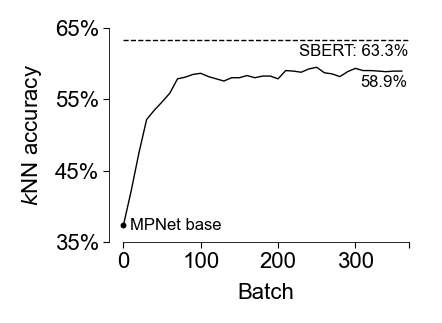

In [50]:
%matplotlib inline
from matplotlib import ticker

model_name = "MPNet"

fig, ax = plt.subplots(
    figsize=(2.25, 1.5),
    dpi=200,
    # width_ratios=[0.3, 0.3, 0.4],
    layout="constrained",
)
txtkwargs = dict(size=8, weight="bold", va="top", ha="left")
titlekwargs = dict(size=8, va="top", ha="center")

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)


## (b)
# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_eval_iclr_v1.npy",
)
# plot
ax.set_aspect((370 / 0.3) * (3 / 4))
ax.plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0],
    label="ICLR",
    c="k",
)
ax.text(
    368,
    np.vstack(knn_accuracies_iclr)[:, 0][-1] - 0.005,
    f"{np.vstack(knn_accuracies_iclr)[:, 0][-1]:.1%}",
    # fontsize=5,
    va="top",
    ha="right",
)
ax.hlines(knn_acc_highd_sbert[0], 0, 368, color="k", linestyles="--")
ax.text(
    368,
    knn_acc_highd_sbert[0] - 0.005,
    f"SBERT: {knn_acc_highd_sbert[0]:.1%}",
    # fontsize=5,
    va="top",
    ha="right",
)
ax.scatter(0, knn_acc_highd[0], c="k", s=5)
ax.text(
    8,
    knn_acc_highd[0],
    f"MPNet base",
    # fontsize=5,
    va="center",
    ha="left",
)
ax.set_ylim(0.35, 0.65)
ax.set_yticks(np.arange(0.35, 0.75, 0.1))
ax.set_xticks([0, 100, 200, 300, 370])
ax.set_xticklabels([0, 100, 200, 300, ""])
ax.set_xlabel("Batch")
ax.set_ylabel("$k$NN accuracy")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.spines.bottom.set_bounds(0, 370)
# letter and title
# axs1_title = fig.add_axes(
#     [
#         0.013157849166890997 + 0.29643807395702737,
#         0.041831176849881024,
#         0.31040710562414286 + 0.05106986562779636,
#         0.8801662437850396,
#     ]
# )  # left, bottom, width, height
# # axs1_title.text(
# #     0.5, 1.07, "kNN accuracy", transform=axs1_title.transAxes, **titlekwargs
# # )
# ax.text(
#     0,
#     1.07,
#     string.ascii_lowercase[1],
#     transform=ax.transAxes,
#     **txtkwargs,
# )
# axs1_title.axis("off")


fig.savefig(figures_path / "fig1_v12.png")
fig.savefig(figures_path / "fig1_v12.pdf")

# Figure 2

In [170]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]

In [171]:
colormap = plt.get_cmap("tab10")
dict_original_colors = dict()
for i, model_name in enumerate(model_names):
    color = colormap(i)
    dict_original_colors[model_name] = colormap(i)

In [172]:
dict_original_colors["random_bert"] = "black"

In [173]:
# new order
model_names = [
    "random_bert",
    "MPNet",
    "BERT",
    "SciBERT",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER",
    "SPECTER2",
    "SBERT",
]

In [174]:
# new order
model_labels = [
    "Random",
    "MPNet",
    "BERT",
    "SciBERT",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER",
    "SPECTER2",
    "SBERT",
]

In [175]:
def plot_squared_brackets(ax, x, y, text, width, height):
    text_kwargs = dict(
        fontsize=6,
        ha="center",
        va="bottom",
    )
    ax.text(x, y - 0.03, text, **text_kwargs)

    lw = 0.35
    color = "k"
    ax.plot([x - width / 2, x + width / 2], [y, y], lw=lw, color=color)
    ax.plot(
        [x - width / 2, x - width / 2], [y, y + height], lw=lw, color=color
    )
    ax.plot(
        [x + width / 2, x + width / 2], [y, y + height], lw=lw, color=color
    )

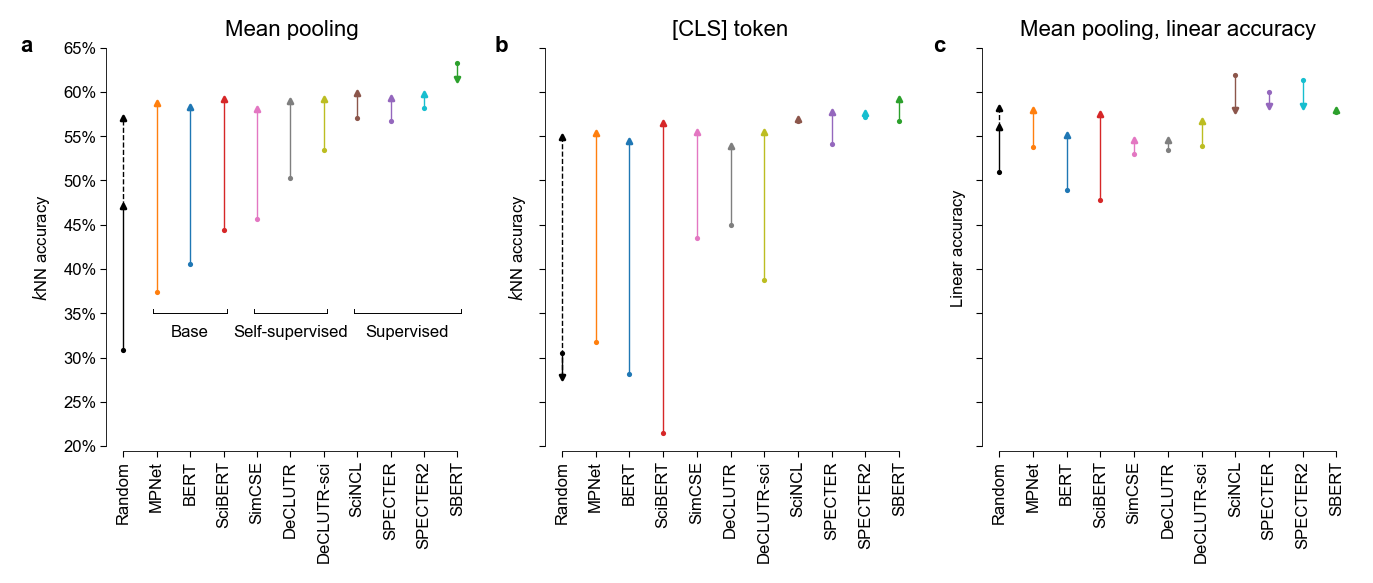

In [176]:
%matplotlib inline

fig, axs = plt.subplots(
    1, 3, figsize=(6.75, 2.8), dpi=200, layout="constrained", sharey=True
)

for i, model_name in enumerate(model_names):
    ## AV
    # load things
    # if model_name == "Random":
    #     saving_path = Path("embeddings_random_bert") / Path("updated_dataset")
    # else:
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run1.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    color = dict_original_colors[model_name]
    rep = 0

    axs[0].plot(
        np.ones(2) * i,
        np.array([knn_accuracies_before[rep], knn_accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,
        # marker=".",
        # ms=3,
    )
    axs[0].scatter(
        i,
        knn_accuracies_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if knn_accuracies_before[rep] <= knn_accuracies_after[0, rep]:
        axs[0].scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        axs[0].scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )
    if model_name == "random_bert":
        axs[0].plot(
            np.ones(2) * i,
            np.array(
                [knn_accuracies_after[0, rep], knn_accuracies_after[-1, rep]]
            ),
            label=f"{model_name}",
            color=color,
            linestyle="--",
            # marker=".",
            # ms=3,
        )
        axs[0].scatter(
            i,
            knn_accuracies_after[-1, rep],
            color=color,
            marker="^",
            s=3,
        )

    ## CLS
    # load things
    # saving_path = Path("embeddings_" + model_name.lower()) / Path(
    #     "updated_dataset"
    # )

    losses = np.load(variables_path / saving_path / "losses_run3.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run3.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    # color = dict_original_colors[model_name]
    rep = 1

    axs[1].plot(
        np.ones(2) * i,
        np.array([knn_accuracies_before[rep], knn_accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,
        # marker=".",
        # ms=3,
    )
    axs[1].scatter(
        i,
        knn_accuracies_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if knn_accuracies_before[rep] <= knn_accuracies_after[0, rep]:
        axs[1].scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        axs[1].scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )
    if model_name == "random_bert":
        axs[1].plot(
            np.ones(2) * i,
            np.array(
                [knn_accuracies_after[0, rep], knn_accuracies_after[-1, rep]]
            ),
            label=f"{model_name}",
            color=color,
            linestyle="--",
            # marker=".",
            # ms=3,
        )
        axs[1].scatter(
            i,
            knn_accuracies_after[-1, rep],
            color=color,
            marker="^",
            s=3,
        )

    ## linear
    # load things
    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    losses = np.load(variables_path / saving_path / "losses_run6.npy")
    accuracies_after = np.load(
        variables_path / saving_path / "linear_accuracy_run6.npy"
    )
    accuracy_before = np.load(
        variables_path / saving_path / "linear_accuracy.npy"
    )

    rep = 0

    axs[2].plot(
        np.ones(2) * i,
        np.array([accuracy_before[rep], accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,
        # marker=".",
        # ms=3,
    )
    axs[2].scatter(
        i,
        accuracy_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if accuracy_before[rep] <= accuracies_after[0, rep]:
        axs[2].scatter(
            i,
            accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        axs[2].scatter(
            i,
            accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )
    if model_name == "random_bert":
        axs[2].plot(
            np.ones(2) * i,
            np.array([accuracies_after[0, rep], accuracies_after[-1, rep]]),
            label=f"{model_name}",
            color=color,
            linestyle="--",
            # marker=".",
            # ms=3,
        )
        axs[2].scatter(
            i,
            accuracies_after[-1, rep],
            color=color,
            marker="^",
            s=3,
        )


# OUTSIDE OF THE LOOP

axs[0].set_xticks(np.arange(len(model_names)))
axs[0].set_xticklabels(model_labels, rotation="vertical")
# axs[0].set_ylim(0.2, 0.65)
axs[0].set_ylabel("$k$NN accuracy")
# axs[0].legend(loc="lower right")
axs[0].set_title("Mean pooling")
axs[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs[0].set_yticks(np.arange(0.2, 0.7, 0.05))
axs[0].spines.left.set_bounds(0.2, 0.65)
axs[0].spines.bottom.set_bounds(0, len(model_names) - 1)
axs[0].text(
    -0.2,
    1.02,
    string.ascii_lowercase[0],
    transform=axs[0].transAxes,
    **txtkwargs,
)

plot_squared_brackets(axs[0], 1 + 1, 0.35, "Base", 2.2, 0.005)
plot_squared_brackets(axs[0], 1 + 4, 0.35, "Self-supervised", 2.2, 0.005)
plot_squared_brackets(axs[0], 1 + 7.5, 0.35, "Supervised", 3.2, 0.005)


axs[1].set_xticks(np.arange(len(model_names)))
axs[1].set_xticklabels(model_labels, rotation="vertical")
# axs[1].set_ylim(0.2, 0.65)
axs[1].set_ylabel("$k$NN accuracy ")
# axs[1].legend(loc="lower right")
axs[1].set_title("[CLS] token")
axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
# axs[1].set_yticks(np.arange(0.2, 0.7, 0.05))
axs[1].spines.left.set_bounds(0.2, 0.65)
axs[1].spines.bottom.set_bounds(0, len(model_names) - 1)
axs[1].text(
    -0.1,
    1.02,
    string.ascii_lowercase[1],
    transform=axs[1].transAxes,
    **txtkwargs,
)

axs[2].set_xticks(np.arange(len(model_names)))
axs[2].set_xticklabels(model_labels, rotation="vertical")
# axs[2].set_ylim(0.2, 0.65)
axs[2].set_ylabel("Linear accuracy")
# axs[2].legend(loc="lower right")
axs[2].set_title("Mean pooling, linear accuracy", fontsize=8)
axs[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
# axs[2].set_yticks(np.arange(0.2, 0.7, 0.05))
axs[2].spines.left.set_bounds(0.2, 0.65)
axs[2].spines.bottom.set_bounds(0, len(model_names) - 1)
axs[2].text(
    -0.1,
    1.02,
    string.ascii_lowercase[2],
    transform=axs[2].transAxes,
    **txtkwargs,
)

fig.savefig(figures_path / "fig2_v6.png")
fig.savefig(figures_path / "fig2_v6.pdf")

## Print accuracy values

knn acc av:  MPNet, 0.374, 0.588
knn acc cls:  MPNet, 0.318, 0.553
linear acc av:  MPNet, 0.538, 0.579
-------------------------------------
knn acc av:  BERT, 0.406, 0.583
knn acc cls:  BERT, 0.282, 0.545
linear acc av:  BERT, 0.489, 0.551
-------------------------------------
knn acc av:  SciBERT, 0.445, 0.592
knn acc cls:  SciBERT, 0.215, 0.565
linear acc av:  SciBERT, 0.478, 0.575
-------------------------------------
knn acc av:  SimCSE, 0.457, 0.581
knn acc cls:  SimCSE, 0.435, 0.555
linear acc av:  SimCSE, 0.530, 0.545
-------------------------------------
knn acc av:  DeCLUTR, 0.503, 0.590
knn acc cls:  DeCLUTR, 0.450, 0.538
linear acc av:  DeCLUTR, 0.535, 0.545
-------------------------------------
knn acc av:  DeCLUTR-sci, 0.535, 0.592
knn acc cls:  DeCLUTR-sci, 0.388, 0.555
linear acc av:  DeCLUTR-sci, 0.539, 0.567
-------------------------------------
knn acc av:  SciNCL, 0.570, 0.598
knn acc cls:  SciNCL, 0.568, 0.569
linear acc av:  SciNCL, 0.619, 0.579
------------------

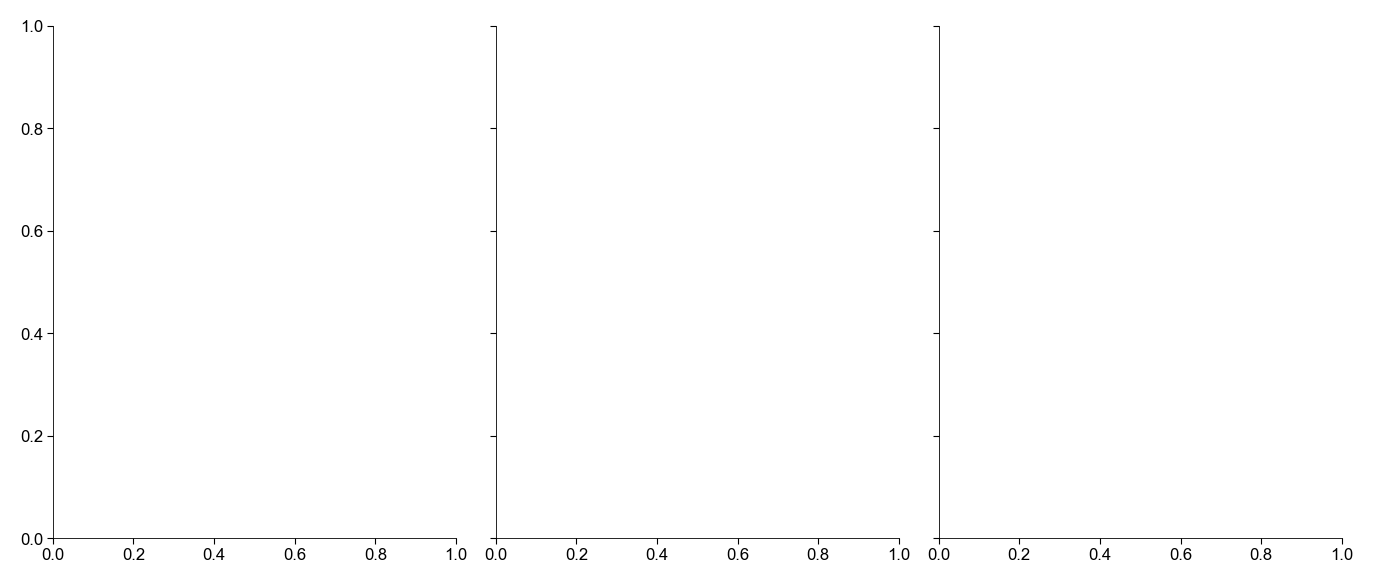

In [15]:
%matplotlib inline

fig, axs = plt.subplots(
    1, 3, figsize=(6.75, 2.8), dpi=200, layout="constrained", sharey=True
)
final_performance_cls_poling = []
final_performance_mean_poling = []
for i, model_name in enumerate(model_names):
    ## AV
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run1.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    rep = 0

    print(
        f"knn acc av:  {model_name}, {knn_accuracies_before[rep]:.3f}, {knn_accuracies_after[0, rep]:.3f}"
    )
    final_performance_mean_poling.append(knn_accuracies_after[0, rep])

    ## CLS
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run3.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run3.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    # color = dict_original_colors[model_name]
    rep = 1
    print(
        f"knn acc cls:  {model_name}, {knn_accuracies_before[rep]:.3f}, {knn_accuracies_after[0, rep]:.3f}"
    )
    final_performance_cls_poling.append(knn_accuracies_after[0, rep])

    ## linear
    # load things
    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    losses = np.load(variables_path / saving_path / "losses_run6.npy")
    accuracies_after = np.load(
        variables_path / saving_path / "linear_accuracy_run6.npy"
    )
    accuracy_before = np.load(
        variables_path / saving_path / "linear_accuracy.npy"
    )

    rep = 0
    print(
        f"linear acc av:  {model_name}, {accuracy_before[rep]:.3f}, {accuracies_after[0, rep]:.3f}"
    )
    print("-------------------------------------")

In [125]:
%matplotlib inline


final_performance_cls_poling = []
final_performance_mean_poling = []
for i, model_name in enumerate(model_names):
    ## AV
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run1.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    rep = 0

    print(
        f"& {knn_accuracies_before[rep]*100:.1f}\% & {knn_accuracies_after[0, rep]*100:.2f}\% \\\\"
    )
    final_performance_mean_poling.append(knn_accuracies_after[0, rep])

    # ## CLS
    # # load things
    # saving_path = Path("embeddings_" + model_name.lower()) / Path(
    #     "updated_dataset"
    # )

    # losses = np.load(variables_path / saving_path / "losses_run3.npy")
    # knn_accuracies_after = np.load(
    #     variables_path / saving_path / "knn_accuracies_run3.npy"
    # )

    # saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    # knn_accuracies_before = np.load(
    #     variables_path / "updated_dataset" / saving_name_2
    # )

    # # color = dict_original_colors[model_name]
    # rep = 1
    # print(
    #     f"knn acc cls:  {model_name}, {knn_accuracies_before[rep]:.3f}, {knn_accuracies_after[0, rep]:.3f}"
    # )
    # final_performance_cls_poling.append(knn_accuracies_after[0, rep])

    # ## linear
    # # load things
    # losses = np.load(variables_path / saving_path / "losses_run1.npy")
    # losses = np.load(variables_path / saving_path / "losses_run6.npy")
    # accuracies_after = np.load(
    #     variables_path / saving_path / "linear_accuracy_run6.npy"
    # )
    # accuracy_before = np.load(
    #     variables_path / saving_path / "linear_accuracy.npy"
    # )

    # rep = 0
    # print(
    #     f"linear acc av:  {model_name}, {accuracy_before[rep]:.3f}, {accuracies_after[0, rep]:.3f}"
    # )
    # print("-------------------------------------")

& 37.4\% & 58.77\% \\
& 40.6\% & 58.31\% \\
& 44.5\% & 59.23\% \\
& 45.7\% & 58.08\% \\
& 50.3\% & 59.00\% \\
& 53.5\% & 59.15\% \\
& 57.0\% & 59.85\% \\
& 56.8\% & 59.31\% \\
& 58.2\% & 59.77\% \\
& 63.3\% & 61.46\% \\


In [24]:
print(
    np.mean(
        np.array(final_performance_mean_poling) * 100
        - np.array(final_performance_cls_poling) * 100
    )
)

3.0384615384615414


In [25]:
print(
    np.std(
        np.array(final_performance_mean_poling) * 100
        - np.array(final_performance_cls_poling) * 100
    )
)

0.9749829311205054


# Figure 3

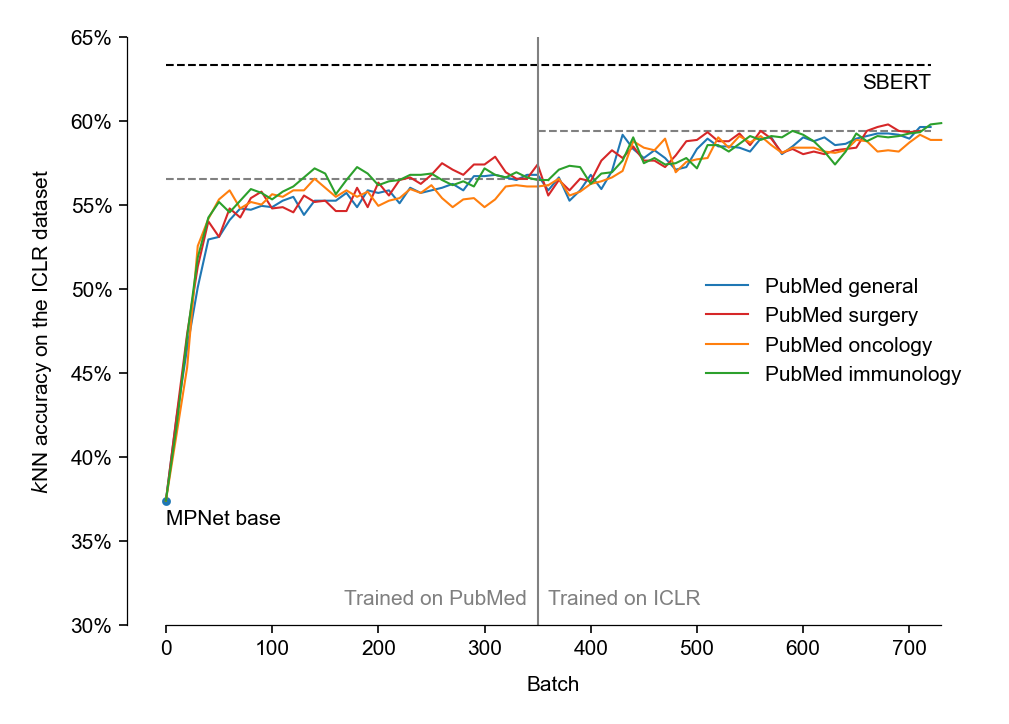

In [116]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"

# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
## random
# PubMed
knn_accuracies_pubmed = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_eval_iclr_v1.npy",
)
## surgery
# PubMed
knn_accuracies_pubmed_surgery = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_surgery_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr_surgery = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_surgery_eval_iclr_v1.npy",
)

## cancer
# PubMed
knn_accuracies_pubmed_cancer = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_cancer_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr_cancer = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_cancer_eval_iclr_v1.npy",
)

## immunology
# PubMed
knn_accuracies_pubmed_immunology = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_immunology_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr_immunology = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_immunology_eval_iclr_v1.npy",
)


y_lim_bottom = 0.3
y_lim_top = 0.65

# lines
ax.hlines(
    0.565,
    0,
    (len(knn_accuracies_pubmed) - 1) * 10,
    color="grey",  # "#48494B",
    linestyle="--",
)
ax.hlines(
    0.594,
    (len(knn_accuracies_pubmed) - 1) * 10,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="grey",  # "#48494B",
    linestyle="--",
)

## AV
# random
ax.plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 0],
    label="PubMed general",
    color="tab:blue",
    linestyle="-",
)

ax.plot(
    (len(knn_accuracies_pubmed) - 1) * 10
    + np.arange(len(knn_accuracies_iclr)) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0],
    # label="ICLR",
    color="tab:blue",
    linestyle="-",
)
# surgery
ax.plot(
    np.arange(len(knn_accuracies_pubmed_surgery)) * 10,
    np.vstack(knn_accuracies_pubmed_surgery)[:, 0],
    label="PubMed surgery",
    color="tab:red",
    linestyle="-",
)
ax.plot(
    (len(knn_accuracies_pubmed_surgery) - 1) * 10
    + np.arange(len(knn_accuracies_iclr_surgery)) * 10,
    np.vstack(knn_accuracies_iclr_surgery)[:, 0],
    # label="ICLR",
    color="tab:red",
    linestyle="-",
)
# cancer
ax.plot(
    np.arange(len(knn_accuracies_pubmed_cancer)) * 10,
    np.vstack(knn_accuracies_pubmed_cancer)[:, 0],
    label="PubMed oncology",
    color="tab:orange",
    linestyle="-",
)
ax.plot(
    (len(knn_accuracies_pubmed_cancer) - 1) * 10
    + np.arange(len(knn_accuracies_iclr_cancer)) * 10,
    np.vstack(knn_accuracies_iclr_cancer)[:, 0],
    # label="ICLR",
    color="tab:orange",
    linestyle="-",
)
# immunology
ax.plot(
    np.arange(len(knn_accuracies_pubmed_immunology)) * 10,
    np.vstack(knn_accuracies_pubmed_immunology)[:, 0],
    label="PubMed immunology",
    color="tab:green",
    linestyle="-",
)
ax.plot(
    (len(knn_accuracies_pubmed_immunology) - 1) * 10
    + np.arange(len(knn_accuracies_iclr_immunology)) * 10,
    np.vstack(knn_accuracies_iclr_immunology)[:, 0],
    # label="ICLR",
    color="tab:green",
    linestyle="-",
)


# ax.plot([], [], c="grey", linestyle="-", label="ICLR")
# SBERT
ax.hlines(
    knn_acc_highd_sbert[0],
    0,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="k",
    linestyles="--",
)
ax.text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    knn_acc_highd_sbert[0] - 0.005,
    f"SBERT",
    fontsize=5,
    va="top",
    ha="right",
)
ax.scatter(0, knn_acc_highd[0], c="tab:blue", s=5)
ax.text(
    0,
    knn_acc_highd[0] - 0.005,
    f"MPNet base",
    fontsize=5,
    va="top",
    ha="left",
)
ax.vlines(
    (len(knn_accuracies_pubmed) - 1) * 10,
    y_lim_bottom,
    y_lim_top,
    color="grey",
    ls="-",
)
ax.text(
    (len(knn_accuracies_pubmed) - 1) * 10 - 10,
    0.31,
    f"Trained on PubMed",
    fontsize=5,
    va="bottom",
    ha="right",
    color="grey",
)
ax.text(
    (len(knn_accuracies_pubmed) - 1) * 10 + 10,
    0.31,
    f"Trained on ICLR",
    fontsize=5,
    va="bottom",
    ha="left",
    color="grey",
)
ax.legend(loc="center right")
ax.set_ylim(y_lim_bottom, y_lim_top)
# ax.set_xlim(left=0)
ax.set_xlabel("Batch")
ax.set_ylabel("$k$NN accuracy on the ICLR dataset")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_yticks(np.arange(0.3, 0.7, 0.05))
ax.spines.left.set_bounds(0.3, 0.65)
ax.set_xticks([0, 100, 200, 300, 400, 500, 600, 700])
ax.set_xticklabels([0, 100, 200, 300, 400, 500, 600, 700])
ax.spines.bottom.set_bounds(
    0,
    730,  # (len(knn_accuracies_pubmed)) * 10 + (len(knn_accuracies_iclr)) * 10,
)


fig.savefig(figures_path / "fig3_v6.png")
fig.savefig(figures_path / "fig3_v6.pdf")

## Print values

In [88]:
%matplotlib inline

# fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"

# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
## random
# PubMed
knn_accuracies_pubmed = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_eval_iclr_v1.npy",
)
## surgery
# PubMed
knn_accuracies_pubmed_surgery = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_surgery_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr_surgery = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_surgery_eval_iclr_v1.npy",
)

## cancer
# PubMed
knn_accuracies_pubmed_cancer = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_cancer_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr_cancer = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_cancer_eval_iclr_v1.npy",
)

## immunology
# PubMed
knn_accuracies_pubmed_immunology = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_immunology_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr_immunology = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_immunology_eval_iclr_v1.npy",
)


print(f"Random pubmed: {np.vstack(knn_accuracies_pubmed)[0, 0]:.3f}, {np.vstack(knn_accuracies_pubmed)[-1, 0]:.3f}")
print(f"Random pubmed ICLR: {np.vstack(knn_accuracies_iclr)[0, 0]:.3f}, {np.vstack(knn_accuracies_iclr)[-1, 0]:.3f}")
print("---------------------------")


print(f"surgery pubmed: {np.vstack(knn_accuracies_pubmed_surgery)[0, 0]:.3f}, {np.vstack(knn_accuracies_pubmed_surgery)[-1, 0]:.3f}")
print(f"surgery pubmed ICLR: {np.vstack(knn_accuracies_iclr_surgery)[0, 0]:.3f}, {np.vstack(knn_accuracies_iclr_surgery)[-1, 0]:.3f}")
print("---------------------------")

print(f"cancer pubmed: {np.vstack(knn_accuracies_pubmed_cancer)[0, 0]:.3f}, {np.vstack(knn_accuracies_pubmed_cancer)[-1, 0]:.3f}")
print(f"cancer pubmed ICLR: {np.vstack(knn_accuracies_iclr_cancer)[0, 0]:.3f}, {np.vstack(knn_accuracies_iclr_cancer)[-1, 0]:.3f}")
print("---------------------------")

print(f"immunology pubmed: {np.vstack(knn_accuracies_pubmed_immunology)[0, 0]:.3f}, {np.vstack(knn_accuracies_pubmed_immunology)[-1, 0]:.3f}")
print(f"immunology pubmed ICLR: {np.vstack(knn_accuracies_iclr_immunology)[0, 0]:.3f}, {np.vstack(knn_accuracies_iclr_immunology)[-1, 0]:.3f}")
print("---------------------------")



Random pubmed: 0.374, 0.568
Random pubmed ICLR: 0.568, 0.596
---------------------------
surgery pubmed: 0.374, 0.565
surgery pubmed ICLR: 0.565, 0.594
---------------------------
cancer pubmed: 0.374, 0.562
cancer pubmed ICLR: 0.562, 0.588
---------------------------
immunology pubmed: 0.374, 0.565
immunology pubmed ICLR: 0.565, 0.598
---------------------------


In [91]:
# (0.568 + 0.565 + 0.562 + 0.565) / 4
(0.596 + 0.594 + 0.588 + 0.598) / 4

0.594

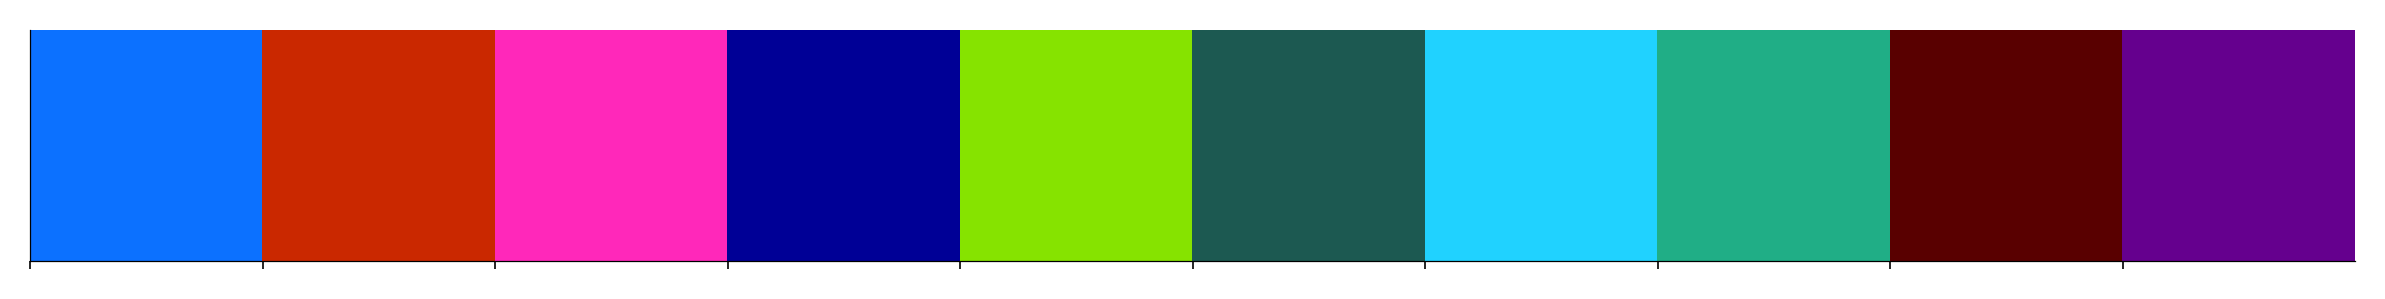

In [121]:
%matplotlib inline
import glasbey
import seaborn as sns

# old one
palette = glasbey.create_palette(
    palette_size=10,
    # lightness_bounds=(20, 75),
    # chroma_bounds=(30, 90),
    colorblind_safe=True,
)
sns.palplot(palette)

In [119]:
?glasbey.create_palette

Signature:
glasbey.create_palette(
    palette_size: int = 256,
    *,
    grid_size: Union[int, Tuple[int, int, int]] = 64,
    as_hex: bool = True,
    grid_space: Literal['RGB', 'JCh'] = 'RGB',
    lightness_bounds: Tuple[float, float] = (10, 90),
    chroma_bounds: Tuple[float, float] = (10, 90),
    hue_bounds: Tuple[float, float] = (0, 360),
    red_bounds: Tuple[float, float] = (0, 1),
    green_bounds: Tuple[float, float] = (0, 1),
    blue_bounds: Tuple[float, float] = (0, 1),
    colorblind_safe: bool = False,
    cvd_type: Literal['protanomaly', 'deuteranomaly', 'tritanomaly'] = 'deuteranomaly',
    cvd_severity: float = 50.0,
) -> Union[List[str], numpy.ndarray]
Docstring:
Create a categorical color palette with ``palette_size`` many colours using the Glasbey algorithm with the
given bounds on hue, chroma and lightness. This should generate a palette that maximizes the perceptual distances
between colours in the palette up to the constraints on hue, chroma and lightness, an

## New version

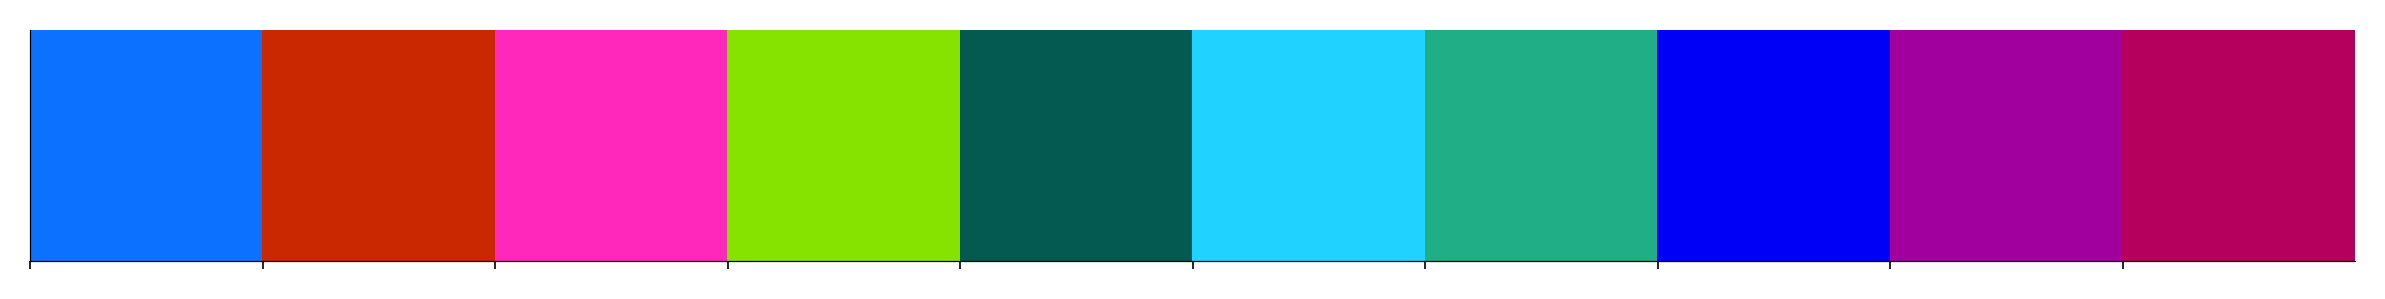

In [34]:
%matplotlib inline
import glasbey
import seaborn as sns

# old one
palette = glasbey.create_palette(
    palette_size=10,
    lightness_bounds=(20, 75),
    chroma_bounds=(30, 90),
    colorblind_safe=True,
)
sns.palplot(palette)

In [32]:
palette[0]

'#0c71ff'

In [31]:
2.25 * 2.3 / 3.25

1.5569230769230769

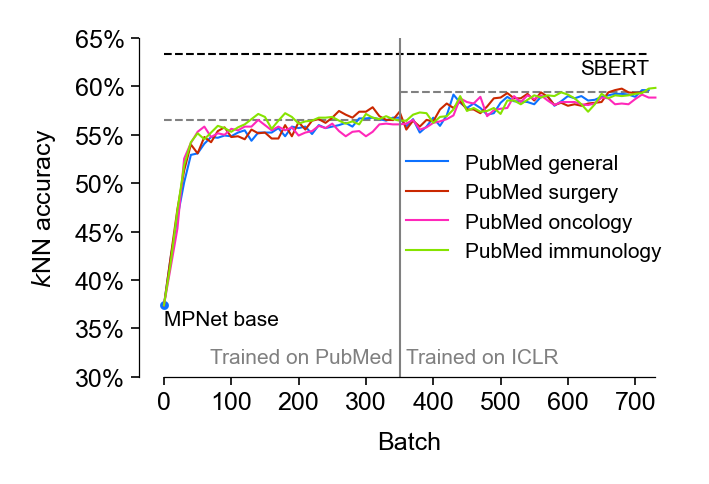

In [41]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2.25, 1.5), dpi=300, layout="constrained")

model_name = "MPNet"

# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
## random
# PubMed
knn_accuracies_pubmed = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_eval_iclr_v1.npy",
)
## surgery
# PubMed
knn_accuracies_pubmed_surgery = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_surgery_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr_surgery = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_surgery_eval_iclr_v1.npy",
)

## cancer
# PubMed
knn_accuracies_pubmed_cancer = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_cancer_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr_cancer = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_cancer_eval_iclr_v1.npy",
)

## immunology
# PubMed
knn_accuracies_pubmed_immunology = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_immunology_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr_immunology = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_immunology_eval_iclr_v1.npy",
)


y_lim_bottom = 0.3
y_lim_top = 0.65

# lines
ax.hlines(
    0.565,
    0,
    (len(knn_accuracies_pubmed) - 1) * 10,
    color="grey",  # "#48494B",
    linestyle="--",
)
ax.hlines(
    0.594,
    (len(knn_accuracies_pubmed) - 1) * 10,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="grey",  # "#48494B",
    linestyle="--",
)

## AV
# random
ax.plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 0],
    label="PubMed general",
    color=palette[0],  # "tab:blue",
    linestyle="-",
)

ax.plot(
    (len(knn_accuracies_pubmed) - 1) * 10
    + np.arange(len(knn_accuracies_iclr)) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0],
    # label="ICLR",
    color=palette[0],  # "tab:blue",
    linestyle="-",
)
# surgery
ax.plot(
    np.arange(len(knn_accuracies_pubmed_surgery)) * 10,
    np.vstack(knn_accuracies_pubmed_surgery)[:, 0],
    label="PubMed surgery",
    color=palette[1],  # "tab:red",
    linestyle="-",
)
ax.plot(
    (len(knn_accuracies_pubmed_surgery) - 1) * 10
    + np.arange(len(knn_accuracies_iclr_surgery)) * 10,
    np.vstack(knn_accuracies_iclr_surgery)[:, 0],
    # label="ICLR",
    color=palette[1],  # "tab:red",
    linestyle="-",
)
# cancer
ax.plot(
    np.arange(len(knn_accuracies_pubmed_cancer)) * 10,
    np.vstack(knn_accuracies_pubmed_cancer)[:, 0],
    label="PubMed oncology",
    color=palette[2],  # "tab:orange",
    linestyle="-",
)
ax.plot(
    (len(knn_accuracies_pubmed_cancer) - 1) * 10
    + np.arange(len(knn_accuracies_iclr_cancer)) * 10,
    np.vstack(knn_accuracies_iclr_cancer)[:, 0],
    # label="ICLR",
    color=palette[2],  # "tab:orange",
    linestyle="-",
)
# immunology
ax.plot(
    np.arange(len(knn_accuracies_pubmed_immunology)) * 10,
    np.vstack(knn_accuracies_pubmed_immunology)[:, 0],
    label="PubMed immunology",
    color=palette[3],  # "tab:green",
    linestyle="-",
)
ax.plot(
    (len(knn_accuracies_pubmed_immunology) - 1) * 10
    + np.arange(len(knn_accuracies_iclr_immunology)) * 10,
    np.vstack(knn_accuracies_iclr_immunology)[:, 0],
    # label="ICLR",
    color=palette[3],  # "tab:green",
    linestyle="-",
)


# ax.plot([], [], c="grey", linestyle="-", label="ICLR")
# SBERT
ax.hlines(
    knn_acc_highd_sbert[0],
    0,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="k",
    linestyles="--",
)
ax.text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    knn_acc_highd_sbert[0] - 0.005,
    f"SBERT",
    fontsize=5,
    va="top",
    ha="right",
)
ax.scatter(0, knn_acc_highd[0], c=palette[0], s=5)
ax.text(
    0,
    knn_acc_highd[0] - 0.005,
    f"MPNet base",
    fontsize=5,
    va="top",
    ha="left",
)
ax.vlines(
    (len(knn_accuracies_pubmed) - 1) * 10,
    y_lim_bottom,
    y_lim_top,
    color="grey",
    ls="-",
)
ax.text(
    (len(knn_accuracies_pubmed) - 1) * 10 - 10,
    0.31,
    f"Trained on PubMed",
    fontsize=5,
    va="bottom",
    ha="right",
    color="grey",
)
ax.text(
    (len(knn_accuracies_pubmed) - 1) * 10 + 10,
    0.31,
    f"Trained on ICLR",
    fontsize=5,
    va="bottom",
    ha="left",
    color="grey",
)
ax.legend(loc="center right")
ax.set_ylim(y_lim_bottom, y_lim_top)
# ax.set_xlim(left=0)
ax.set_xlabel("Batch")
# ax.set_ylabel("$k$NN accuracy on the ICLR dataset")
ax.set_ylabel("$k$NN accuracy")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_yticks(np.arange(0.3, 0.7, 0.05))
ax.spines.left.set_bounds(0.3, 0.65)
ax.set_xticks([0, 100, 200, 300, 400, 500, 600, 700])
ax.set_xticklabels([0, 100, 200, 300, 400, 500, 600, 700])
ax.spines.bottom.set_bounds(
    0,
    730,  # (len(knn_accuracies_pubmed)) * 10 + (len(knn_accuracies_iclr)) * 10,
)


fig.savefig(figures_path / "fig3_v8.png")
fig.savefig(figures_path / "fig3_v8.pdf")

# Figure 4

In [203]:
1 / (multipliers * 20)

array([5.   , 0.5  , 0.05 , 0.005])

In [228]:
np.linspace(0.005, 0.05, 24)

array([0.005     , 0.22217391, 0.43934783, 0.65652174, 0.87369565,
       1.09086957, 1.30804348, 1.52521739, 1.7423913 , 1.95956522,
       2.17673913, 2.39391304, 2.61108696, 2.82826087, 3.04543478,
       3.2626087 , 3.47978261, 3.69695652, 3.91413043, 4.13130435,
       4.34847826, 4.56565217, 4.78282609, 5.        ])

In [102]:
mpl.rcParams["xtick.labelsize"] = 5
mpl.rcParams["ytick.labelsize"] = 5
mpl.rcParams["axes.labelsize"] = 5
mpl.rcParams["axes.titlesize"] = 6

[0.36923076923076925, 0.49, 0.553076923076923, 0.5553846153846154]
[0.5561538461538461, 0.5738461538461539, 0.5823076923076923, 0.583076923076923, 0.5876923076923077, 0.5869230769230769, 0.5961538461538461, 0.5992307692307692, 0.0823076923076923, 0.08923076923076922, 0.055384615384615386, 0.05076923076923077]


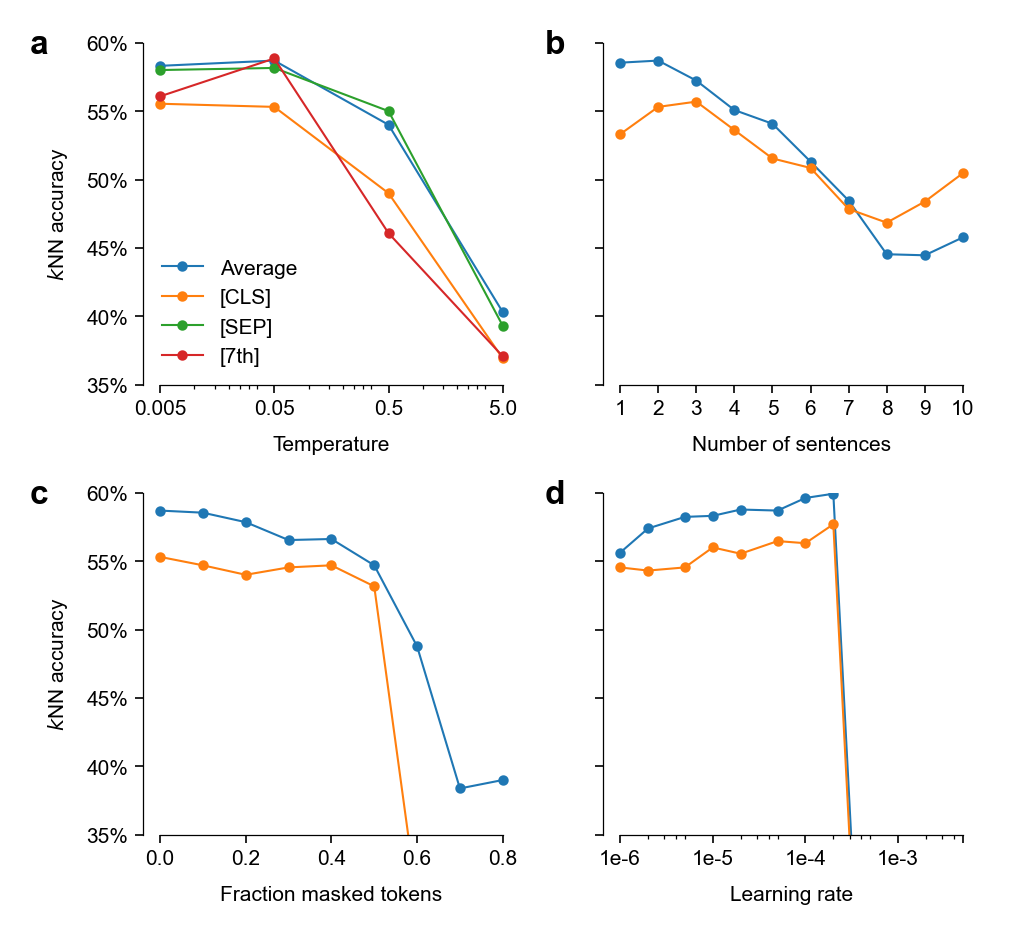

In [104]:
%matplotlib inline
fig, axs = plt.subplots(
    2,
    2,
    figsize=(3.25, 3),
    dpi=300,
    layout="constrained",
    sharey=True,
)
model_name = "MPNet"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
txtkwargs = dict(size=8, weight="bold", va="top", ha="right")

## TEMPERATURE
## load things
multipliers = np.array([0.01, 0.1, 1, 10])
knn_accuracies_av_all = []
knn_accuracies_cls_all = []
knn_accuracies_sep_all = []
knn_accuracies_7th_all = []

for j, mult in enumerate(multipliers):
    # AV
    saving_name_accuracies = Path(
        f"knn_accuracies_av_scale_multiplier_{mult}" + "_v1.npy"
    )
    knn_accuracies_av = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    # CLS
    saving_name_accuracies = Path(
        f"knn_accuracies_cls_scale_multiplier_{mult}" + "_v1.npy"
    )
    knn_accuracies_cls = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    # SEP
    saving_name_accuracies = Path(
        f"knn_accuracies_sep_scale_multiplier_{mult}" + "_v1.npy"
    )
    knn_accuracies_sep = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    # 7th
    saving_name_accuracies = Path(
        f"knn_accuracies_7th_scale_multiplier_{mult}" + "_v1.npy"
    )
    knn_accuracies_7th = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    knn_accuracies_av_all.append(knn_accuracies_av[-1, 0])
    knn_accuracies_cls_all.append(knn_accuracies_cls[-1, 1])
    knn_accuracies_sep_all.append(knn_accuracies_sep[-1, 2])
    knn_accuracies_7th_all.append(knn_accuracies_7th[-1, 3])

## plot
print(knn_accuracies_cls_all)
s_chosen = 3
axs[0, 0].plot(
    1 / (multipliers * 20),
    knn_accuracies_av_all,
    label=f"Average",
    # color="tab:blue",
    ms=s_chosen,
    marker=".",
)
axs[0, 0].plot(
    1 / (multipliers * 20),
    knn_accuracies_cls_all,
    # color="tab:orange",
    label=f"[CLS]",
    ms=s_chosen,
    marker=".",
)
axs[0, 0].plot(
    1 / (multipliers * 20),
    knn_accuracies_sep_all,
    # color="tab:orange",
    label=f"[SEP]",
    ms=s_chosen,
    marker=".",
)
axs[0, 0].plot(
    1 / (multipliers * 20),
    knn_accuracies_7th_all,
    # color="tab:orange",
    label=f"[7th]",
    ms=s_chosen,
    marker=".",
)
## y-axis
axs[0, 0].set_ylim(0.35, 0.6)
axs[0, 0].set_ylabel("$k$NN accuracy")
axs[0, 0].yaxis.set_major_formatter(
    ticker.PercentFormatter(xmax=1, decimals=0)
)
axs[0, 0].spines.left.set_bounds(0.35, 0.6)

## x-axis
axs[0, 0].set_xlabel("Temperature")
axs[0, 0].set_xscale("log")

### attempt 1
# axs[0,0].xaxis.limit_range_for_scale(
#     1 / (multipliers * 20)[-1], 1 / (multipliers * 20)[0]
# )

### attempt 2
axs[0, 0].xaxis.set_minor_locator(
    ticker.LogLocator(
        base=10.0,
        subs=np.arange(0.1, 0.8, 0.1) * 5,
    )
)
axs[0, 0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

### ugly workaround
# axs[0,0].set_xlim(0.00455, 5)
# axs[0,0].set_xlim(0.005, 5)


### add ticks
axs[0, 0].set_xticks(1 / (multipliers * 20))
axs[0, 0].set_xticklabels(1 / (multipliers * 20))

### modify spines
axs[0, 0].spines.bottom.set_bounds(
    1 / (multipliers * 20)[-1], 1 / (multipliers * 20)[0]
)

### other
axs[0, 0].legend()
axs[0, 0].text(
    -0.25,
    1.04,
    string.ascii_lowercase[0],
    transform=axs[0, 0].transAxes,
    **txtkwargs,
)
# axs[0, 0].set_title(f"Temperature")  # , fontsize=title_size)


### N_CONS_SENTENCES
## load things
batch_sizes = [
    128,
    64,
    64,
    64,
    32,
    32,
    32,
    32,
    32,
    16,
]
knn_accuracies_av_all = []
knn_accuracies_cls_all = []

for j, n_cons_sntcs in enumerate(np.arange(1, 11)):
    batchsize = batch_sizes[j]
    saving_name_accuracies = Path(
        "knn_accuracies_av_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_"
        + str(batchsize)
        + "_v1.npy"
    )
    knn_accuracies_av = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    saving_name_accuracies = Path(
        "knn_accuracies_cls_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_"
        + str(batchsize)
        + "_v1.npy"
    )
    knn_accuracies_cls = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    knn_accuracies_av_all.append(knn_accuracies_av[-1, 0])
    knn_accuracies_cls_all.append(knn_accuracies_cls[-1, 1])

## plot
# AV
s_chosen = 3
axs[0, 1].plot(
    np.arange(1, 11),
    knn_accuracies_av_all,
    # label="n_cons_sntcs = " + str(n_cons_sntcs),
    color="tab:blue",
    ms=s_chosen,
    marker=".",
)
axs[0, 1].plot(
    np.arange(1, 11),
    knn_accuracies_cls_all,
    # label="n_cons_sntcs = " + str(n_cons_sntcs),
    color="tab:orange",
    ms=s_chosen,
    marker=".",
)
## x-axis
axs[0, 1].set_xticks(np.arange(1, 11))
axs[0, 1].spines.bottom.set_bounds(1, 10)
axs[0, 1].set_xlabel("Number of sentences")
## y-axis
axs[0, 1].set_ylim(0.35, 0.6)
axs[0, 1].yaxis.set_major_formatter(
    ticker.PercentFormatter(xmax=1, decimals=0)
)
# axs[0, 1].set_ylabel("kNN accuracy")
axs[0, 0].spines.left.set_bounds(0.35, 0.6)
## general
axs[0, 1].legend(loc="upper right")
axs[0, 1].text(
    -0.1,
    1.04,
    string.ascii_lowercase[1],
    transform=axs[0, 1].transAxes,
    **txtkwargs,
)
# axs[0, 1].set_title(f"Number of sentences")  # , fontsize=title_size)


## FRACTION MASKED
## load things
knn_accuracies_av_all = []
knn_accuracies_cls_all = []
# fraction = 0
n_cons_sntcs = 2
saving_name_accuracies = Path(
    "knn_accuracies_av_n_cons_sntcs_"
    + str(n_cons_sntcs)
    + "_batch_size_64_v1.npy"
)
knn_accuracies_av_fraction_masked_0 = np.load(
    variables_path / saving_path / saving_name_accuracies
).reshape(
    -1,
)
saving_name_accuracies = Path(
    "knn_accuracies_cls_n_cons_sntcs_"
    + str(n_cons_sntcs)
    + "_batch_size_64_v1.npy"
)
knn_accuracies_cls_fraction_masked_0 = np.load(
    variables_path / saving_path / saving_name_accuracies
).reshape(
    -1,
)
knn_accuracies_av_all.append(knn_accuracies_av_fraction_masked_0[0])
knn_accuracies_cls_all.append(knn_accuracies_cls_fraction_masked_0[1])

fraction_masked_values = np.arange(0.1, 0.9, 0.1)
for j, frct in enumerate(fraction_masked_values):
    # AV
    saving_name_accuracies = Path(
        f"knn_accuracies_av_fraction_masked_{frct:.1f}"
        + "_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_v1.npy"
    )
    knn_accuracies_av = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    # CLS
    saving_name_accuracies = Path(
        f"knn_accuracies_cls_fraction_masked_{frct:.1f}"
        + "_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_v1.npy"
    )
    knn_accuracies_cls = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    knn_accuracies_av_all.append(knn_accuracies_av[-1, 0])
    knn_accuracies_cls_all.append(knn_accuracies_cls[-1, 1])

## plot
s_chosen = 3
axs[1, 0].plot(
    np.arange(0, 0.9, 0.1),
    knn_accuracies_av_all,
    # label="fraction_masked = " + str(frct),
    color="tab:blue",
    ms=s_chosen,
    marker=".",
)
axs[1, 0].plot(
    np.arange(0, 0.9, 0.1),
    knn_accuracies_cls_all,
    # label="fraction_masked = " + str(frct),
    color="tab:orange",
    ms=s_chosen,
    marker=".",
)
## y-axis
axs[1, 0].set_ylim(0.35, 0.6)
axs[1, 0].yaxis.set_major_formatter(
    ticker.PercentFormatter(xmax=1, decimals=0)
)
# axs[1, 0].set_yticks(np.arange(0.25, 0.65, 0.05))
axs[1, 0].spines.left.set_bounds(0.35, 0.6)
axs[1, 0].set_ylabel("$k$NN accuracy")

## x-axis
axs[1, 0].set_xticks(np.arange(0, 1, 0.2))
axs[1, 0].spines.bottom.set_bounds(0, 0.8)
axs[1, 0].set_xlabel("Fraction masked tokens")
## general
axs[1, 0].legend()
axs[1, 0].text(
    -0.25,
    1.04,
    string.ascii_lowercase[2],
    transform=axs[1, 0].transAxes,
    **txtkwargs,
)
# axs[1, 0].set_title(f"Fraction masked tokens")  # , fontsize=title_size)


### LEARNING RATE
## load things
knn_accuracies_av_all = []
knn_accuracies_cls_all = []
learning_rates = [
    1e-6,
    2e-6,
    5e-6,
    1e-5,
    2e-5,
    5e-5,
    1e-4,
    2e-4,
    5e-4,
    1e-3,
    2e-3,
    5e-3,
]

for j, lr in enumerate(learning_rates):
    # AV
    saving_name_accuracies = Path(
        "knn_accuracies_av_learning_rate_" + str(lr) + "_v1.npy"
    )
    knn_accuracies_av = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    # CLS
    saving_name_accuracies = Path(
        "knn_accuracies_cls_learning_rate_" + str(lr) + "_v1.npy"
    )
    knn_accuracies_cls = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    knn_accuracies_av_all.append(knn_accuracies_av[-1, 0])
    knn_accuracies_cls_all.append(knn_accuracies_cls[-1, 1])

## plot
s_chosen = 3
axs[1, 1].plot(
    learning_rates,
    knn_accuracies_av_all,
    label=f"Average",
    # color="tab:blue",
    ms=s_chosen,
    marker=".",
    clip_on=True,
)
axs[1, 1].plot(
    learning_rates,
    knn_accuracies_cls_all,
    # color="tab:orange",
    label=f"[CLS]",
    ms=s_chosen,
    marker=".",
    clip_on=True,
)
## x-axis
axs[1, 1].set_xlabel("Learning rate")
axs[1, 1].set_xscale("log")
### attempt 2
axs[1, 1].xaxis.set_minor_locator(
    ticker.LogLocator(
        base=10.0,
        subs=np.arange(0.1, 0.6, 0.1),
    )
)
axs[1, 1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
axs[1, 1].set_xticks(
    [
        1e-6,
        1e-5,
        1e-4,
        1e-3,
        5e-3,
    ]
)
axs[1, 1].set_xticklabels(
    [
        "1e-6",
        "1e-5",
        "1e-4",
        "1e-3",
        " ",
    ]
)
# axs[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.0e"))
axs[1, 1].spines.bottom.set_bounds(1e-6, 5e-3)

## y-axis
axs[1, 1].set_ylim(0.35, 0.6)
axs[1, 1].yaxis.set_major_formatter(
    ticker.PercentFormatter(xmax=1, decimals=0)
)
# axs[1, 1].set_ylabel("kNN accuracy")
# axs[1, 1].set_yticks(np.arange(0, 0.7, 0.1))
axs[1, 1].spines.left.set_bounds(0.35, 0.6)

## general
axs[1, 1].text(
    -0.1,
    1.04,
    string.ascii_lowercase[3],
    transform=axs[1, 1].transAxes,
    **txtkwargs,
)

# axs[1, 1].set_title(f"Learning rate")
print(knn_accuracies_av_all)

fig.savefig(figures_path / "fig4_v4.png")
fig.savefig(figures_path / "fig4_v4.pdf")

In [238]:
np.array([0.2, 0.4, 0.6, 0.8]) * 5

array([1., 2., 3., 4.])

In [235]:
axs[0, 0].xaxis.get_minor_ticks()

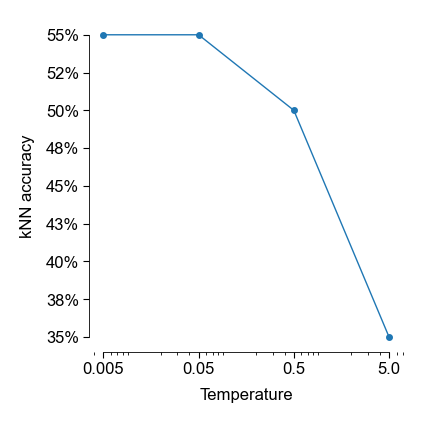

In [70]:
# figure problem
fig, axs = plt.subplots(figsize=(2, 2), dpi=200, layout="constrained")

multipliers = np.array([0.01, 0.1, 1, 10])
knn_accuracies_av_all = [0.35, 0.5, 0.55, 0.55]

## plot
axs.plot(
    1 / (multipliers * 20),
    knn_accuracies_av_all,
    # color="tab:blue",
    ms=3,
    marker=".",
    clip_on=False,
)
## y-axis
# axs.set_ylim(0.34, 0.56)
axs.set_ylabel("kNN accuracy")
axs.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs.spines.left.set_bounds(0.35, 0.55)

## x-axis
axs.set_xlabel("Temperature")
axs.set_xscale("log")

xminor_ticks = axs.xaxis.get_minor_ticks()  # [1:-2]


### attempt 1
# axs.xaxis.limit_range_for_scale(
#     1 / (multipliers * 20)[-1], 1 / (multipliers * 20)[0]
# )

### attempt 2
# axs.xaxis.set_minor_locator(
#     ticker.LogLocator(
#         base=10.0,
#         subs=np.arange(0.1, 0.8, 0.1) * 5,
#     )
# )
# axs.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

### ugly workaround
# axs.set_xlim(0.00455, 5)
# axs.set_xlim(0.005, 5)


### add ticks
axs.set_xticks(1 / (multipliers * 20))
# axs.set_xticks(xminor_ticks, minor=True)  # does not work
axs.set_xticklabels(1 / (multipliers * 20))

### modify spines
axs.spines.bottom.set_bounds(
    1 / (multipliers * 20)[-1], 1 / (multipliers * 20)[0]
)


# fig.savefig(figures_path / "problem_fig_4_with_full_spines.png")
# fig.savefig(figures_path / "problem_fig_4_ugly_workaround.png")

In [66]:
axs.xaxis.get_minor_ticks()[1:-2]

# Fig: freezing experiment

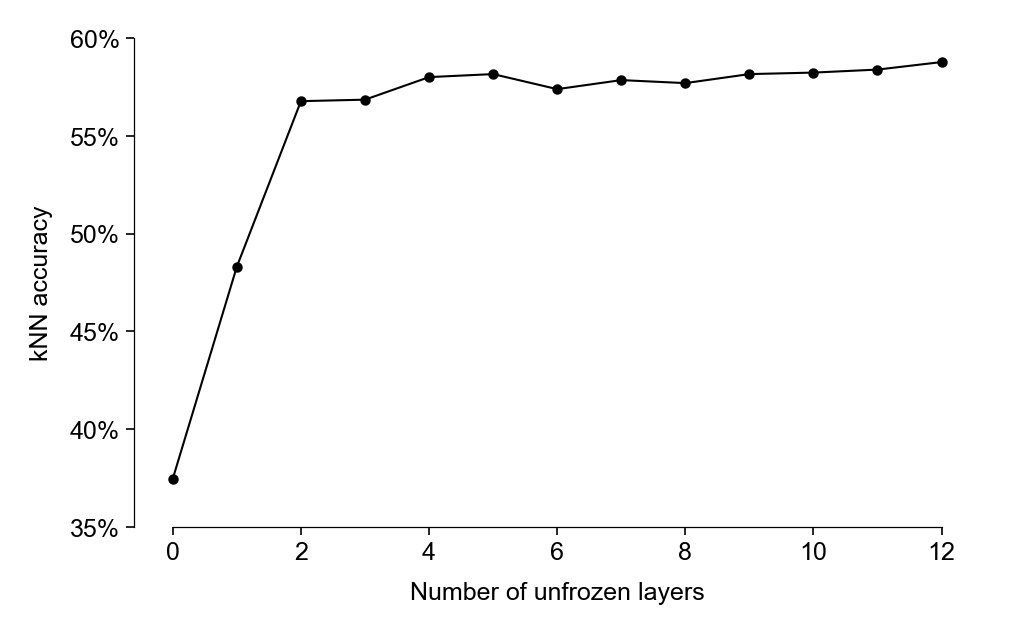

In [19]:
%matplotlib inline


fig, ax = plt.subplots(figsize=(3.25, 2), dpi=300, layout="constrained")

model_name = "MPNet"
knn_accs_all = []
for first_unfrozen_layer in np.flip(np.arange(13)):
    ## save losses and accuracies
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("freezing_experiment")
    )

    # saving_name_losses = Path(
    #     "losses_first_unfrozen_layer_" + str(first_unfrozen_layer) + "_v1"
    # )
    saving_name_accuracies = Path(
        "knn_accuracies_first_unfrozen_layer_"
        + str(first_unfrozen_layer)
        + "_v1.npy"
    )

    # np.load(variables_path / saving_path / saving_name_losses, losses)
    knn_accuracies = np.load(
        variables_path / saving_path / saving_name_accuracies,
    )

    knn_accs_all.append(knn_accuracies[0, 0])

ax.plot(np.arange(13), knn_accs_all, c="k", marker=".", ms=3)
# ax.hlines(0.374, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.374 + 0.001,
#     f"Before fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
# ax.hlines(0.589, 0, 13, color="k", linestyle="--")
# ax.hlines(0.58, 0, 13, color="r", linestyle="-")
# ax.text(
#     0,
#     0.589 + 0.001,
#     f"After fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
ax.set_xlabel("Number of unfrozen layers")
ax.spines.bottom.set_bounds(0, 12)
## y-axis
ax.set_ylim(0.35, 0.6)
ax.set_ylabel("kNN accuracy")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.spines.left.set_bounds(0.35, 0.6)


fig.savefig(figures_path / "freezing_experiment_mpnet_v2.png")

# Fig: guillotine experiment

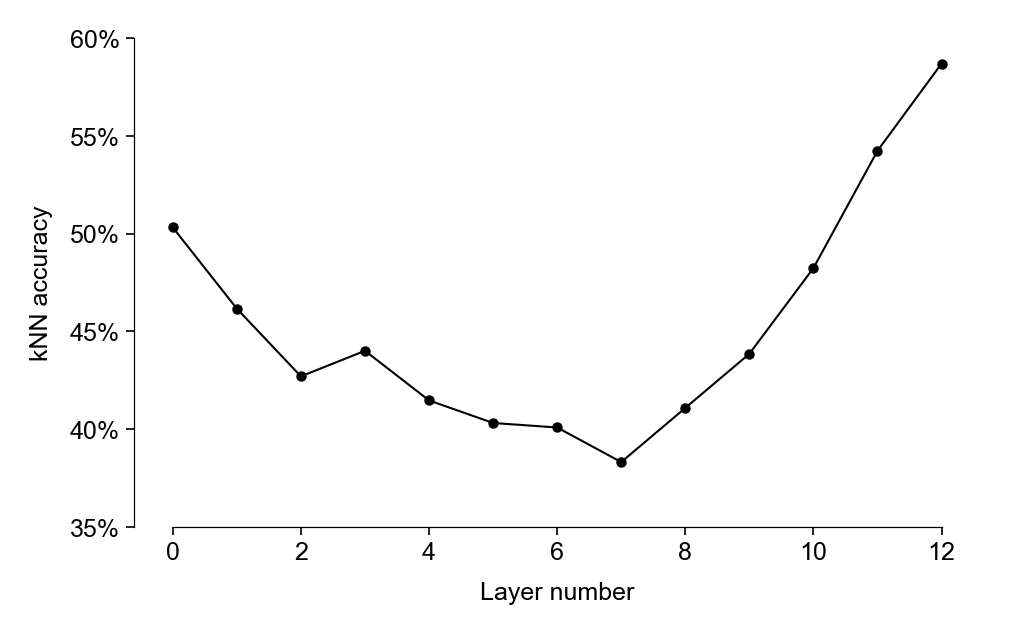

In [20]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2), dpi=300, layout="constrained")

model_name = "MPNet"
knn_accs_all = []
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc = np.load(
        variables_path / saving_path / saving_name,
    )
    # print(layer_number, knn_acc)
    knn_accs_all.append(knn_acc[0])

ax.plot(np.arange(13), knn_accs_all, c="k", ms=3, marker=".")
# ax.hlines(0.374, 0, 12, color="r")
# ax.hlines(0.374, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.374 + 0.001,
#     f"Before fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
# ax.hlines(0.589, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.589 + 0.001,
#     f"After fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
ax.set_xlabel("Layer number")
ax.spines.bottom.set_bounds(0, 12)
## y-axis
ax.set_ylim(0.35, 0.6)
ax.set_ylabel("kNN accuracy")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.spines.left.set_bounds(0.35, 0.6)
# ax.set_title("Guillotine experiment")
fig.savefig(figures_path / "guillotine_experiment_mpnet_v2.png")

## Combined

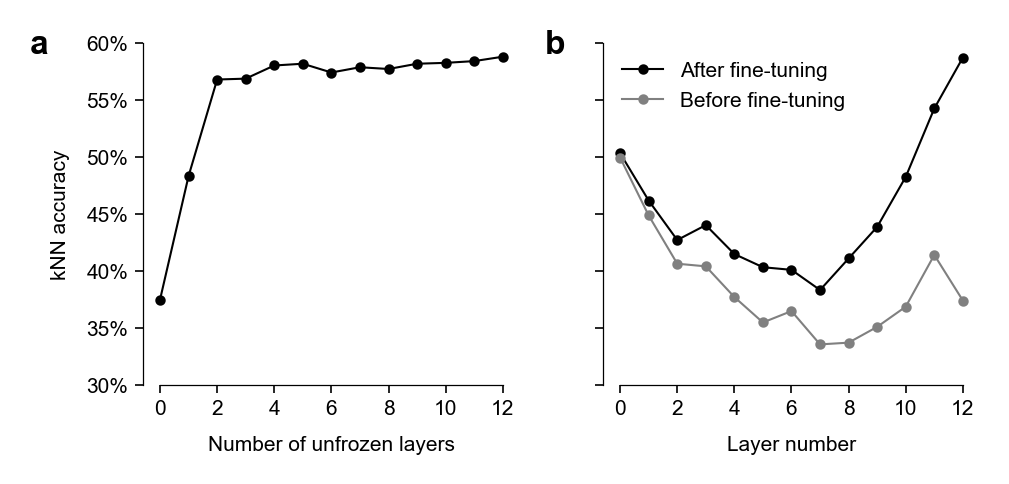

In [124]:
%matplotlib inline


fig, axs = plt.subplots(
    1, 2, figsize=(3.25, 1.5), dpi=300, layout="constrained", sharey=True
)

txtkwargs = dict(size=8, weight="bold", va="top", ha="right")

model_name = "MPNet"
knn_accs_all = []
for first_unfrozen_layer in np.flip(np.arange(13)):
    ## save losses and accuracies
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("freezing_experiment")
    )

    saving_name_accuracies = Path(
        "knn_accuracies_first_unfrozen_layer_"
        + str(first_unfrozen_layer)
        + "_v1.npy"
    )

    knn_accuracies = np.load(
        variables_path / saving_path / saving_name_accuracies,
    )

    knn_accs_all.append(knn_accuracies[0, 0])

axs[0].plot(np.arange(13), knn_accs_all, c="k", marker=".", ms=3)
## x-axis
axs[0].set_xlabel("Number of unfrozen layers")
axs[0].set_xticks(np.arange(0, 14, 2))
axs[0].spines.bottom.set_bounds(0, 12)
## y-axis
axs[0].set_ylim(0.3, 0.6)
axs[0].set_ylabel("kNN accuracy")
axs[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs[0].spines.left.set_bounds(0.3, 0.6)
axs[0].text(
    -0.25,
    1.04,
    string.ascii_lowercase[0],
    transform=axs[0].transAxes,
    **txtkwargs,
)


# panel b
knn_acc_after_all = []
knn_acc_before_all = []

for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )
    # print(layer_number, knn_acc)

    knn_acc_after_all.append(knn_acc_after[0])
    knn_acc_before_all.append(knn_acc_before[0])

axs[1].plot(
    np.arange(13),
    knn_acc_after_all,
    c="k",
    ms=3,
    marker=".",
    label="After fine-tuning",
)
axs[1].plot(
    np.arange(13),
    knn_acc_before_all,
    c="grey",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)
## x-axis
axs[1].set_xlabel("Layer number")
axs[1].set_xticks(np.arange(0, 14, 2))
axs[1].spines.bottom.set_bounds(0, 12)
## y-axis
axs[1].set_ylim(0.3, 0.6)
# axs[1].set_ylabel("kNN accuracy")
axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs[1].spines.left.set_bounds(0.3, 0.6)
axs[1].text(
    -0.1,
    1.04,
    string.ascii_lowercase[1],
    transform=axs[1].transAxes,
    **txtkwargs,
)
axs[1].legend()


fig.savefig(figures_path / "combined_figure_v2.png")
fig.savefig(figures_path / "combined_figure_v2.pdf")

## New version

In [11]:
5.5 * 1.5 / 3.25

2.5384615384615383

In [44]:
mpl.rcParams["xtick.labelsize"] = 8
mpl.rcParams["ytick.labelsize"] = 8
mpl.rcParams["axes.labelsize"] = 8
# mpl.rcParams["axes.titlesize"] = 6

In [45]:
# tab10 colors
tab10_colors = {
    "tab:blue": "#1f77b4",
    "tab:orange": "#ff7f0e",
    "tab:green": "#2ca02c",
    "tab:red": "#d62728",
    "tab:purple": "#9467bd",
    "tab:brown": "#8c564b",
    "tab:pink": "#e377c2",
    "tab:gray": "#7f7f7f",
    "tab:olive": "#bcbd22",
    "tab:cyan": "#17becf",
}

tab10_colors_light = {
    "tab:blue": "#7fbee9",
    "tab:orange": "#ffbf86",
    "tab:green": "#87de87",
    "tab:red": "#eb9293",
    "tab:purple": "#c9b3de",
    "tab:brown": "#cca69f",
    "tab:pink": "#f1bbe0",
    "tab:gray": "#bfbfbf",
    "tab:olive": "#e8e985",
    "tab:cyan": "#81e7f1",
}

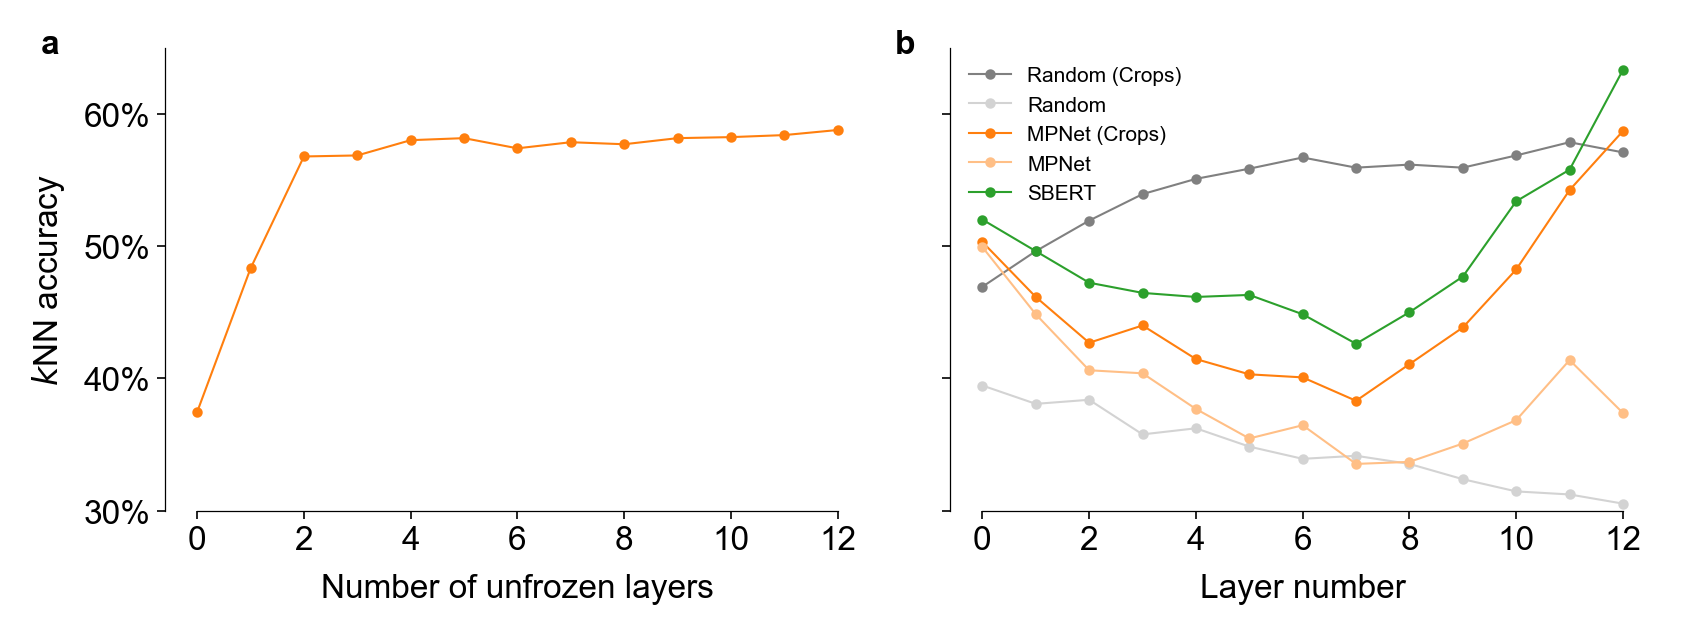

In [78]:
%matplotlib inline


fig, axs = plt.subplots(
    1, 2, figsize=(5.5, 2), dpi=300, layout="constrained", sharey=True
)

txtkwargs = dict(size=8, weight="bold", va="top", ha="right")

fntsz = 8

model_name = "MPNet"
knn_accs_all = []
for first_unfrozen_layer in np.flip(np.arange(13)):
    ## save losses and accuracies
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("freezing_experiment")
    )

    saving_name_accuracies = Path(
        "knn_accuracies_first_unfrozen_layer_"
        + str(first_unfrozen_layer)
        + "_v1.npy"
    )

    knn_accuracies = np.load(
        variables_path / saving_path / saving_name_accuracies,
    )

    knn_accs_all.append(knn_accuracies[0, 0])

axs[0].plot(
    np.arange(13), knn_accs_all, c="tab:orange", marker=".", ms=3  # "k",
)
## x-axis
axs[0].set_xlabel("Number of unfrozen layers")  # , fontsize=fntsz)
axs[0].set_xticks(np.arange(0, 14, 2))
axs[0].spines.bottom.set_bounds(0, 12)
## y-axis
axs[0].set_ylim(0.3, 0.65)
axs[0].set_ylabel("$k$NN accuracy")  # , fontsize=fntsz)
axs[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs[0].spines.left.set_bounds(0.3, 0.65)
axs[0].text(
    -0.15,
    1.04,
    string.ascii_lowercase[0],
    transform=axs[0].transAxes,
    **txtkwargs,
)


# panel b
knn_acc_after_all_mpnet = []
knn_acc_before_all_mpnet = []
knn_acc_before_all_sbert = []
knn_acc_before_all_random = []
knn_acc_after_all_random = []
knn_acc_after_10_all_random = []
for layer_number in np.arange(13):
    # load MPNet
    model_name = "MPNet"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after_mpnet = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before_mpnet = np.load(
        variables_path / saving_path / saving_name,
    )
    # load SBERT
    model_name = "SBERT"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before_sbert = np.load(
        variables_path / saving_path / saving_name,
    )

    # load random BERT
    model_name = "random_bert"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    saving_name = (
        f"knn_accuracies_untrained_av_after_layer_{layer_number}_v1.npy"
    )
    knn_acc_before_random = np.load(
        variables_path / saving_path / saving_name,
    )

    saving_name = (
        f"knn_accuracies_trained_n_epochs_1_av_after_layer_{layer_number}.npy"
    )
    knn_acc_after_random = np.load(
        variables_path / saving_path / saving_name,
    )

    saving_name = (
        f"knn_accuracies_trained_n_epochs_10_av_after_layer_{layer_number}.npy"
    )
    knn_acc_after_10_random = np.load(
        variables_path / saving_path / saving_name,
    )

    # concatenate
    knn_acc_after_all_mpnet.append(knn_acc_after_mpnet[0])
    knn_acc_before_all_mpnet.append(knn_acc_before_mpnet[0])
    knn_acc_before_all_sbert.append(knn_acc_before_sbert[0])
    knn_acc_before_all_random.append(knn_acc_before_random[0])
    knn_acc_after_all_random.append(knn_acc_after_random[0])
    knn_acc_after_10_all_random.append(knn_acc_after_10_random[0])

axs[1].plot(
    np.arange(13),
    knn_acc_after_10_all_random,
    c="grey",
    ms=3,
    marker=".",
    label="Random (Crops)",
)
axs[1].plot(
    np.arange(13),
    knn_acc_before_all_random,
    c="lightgrey",
    ms=3,
    marker=".",
    label="Random",
)
# axs[1].plot(
#     np.arange(13),
#     knn_acc_after_all_random,
#     c="grey",
#     ms=3,
#     marker=".",
#     label=" Random (after 1 epoch)",
# )

axs[1].plot(
    np.arange(13),
    knn_acc_after_all_mpnet,
    c=tab10_colors["tab:orange"],
    ms=3,
    marker=".",
    label="MPNet (Crops)",
)

axs[1].plot(
    np.arange(13),
    knn_acc_before_all_mpnet,
    c=tab10_colors_light["tab:orange"],
    ms=3,
    marker=".",
    label="MPNet",
)


axs[1].plot(
    np.arange(13),
    knn_acc_before_all_sbert,
    c="tab:green",  # tab10_colors_light["tab:green"],
    ms=3,
    marker=".",
    label="SBERT",
)
## x-axis
axs[1].set_xlabel("Layer number")  # , fontsize=fntsz)
axs[1].set_xticks(np.arange(0, 14, 2))
axs[1].spines.bottom.set_bounds(0, 12)
## y-axis
axs[1].set_ylim(0.3, 0.65)
# axs[1].set_ylabel("kNN accuracy")
axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs[1].spines.left.set_bounds(0.3, 0.65)
axs[1].text(
    -0.05,
    1.04,
    string.ascii_lowercase[1],
    transform=axs[1].transAxes,
    **txtkwargs,
)
axs[1].legend()


fig.savefig(figures_path / "combined_figure_v6.png")
fig.savefig(figures_path / "combined_figure_v6.pdf")

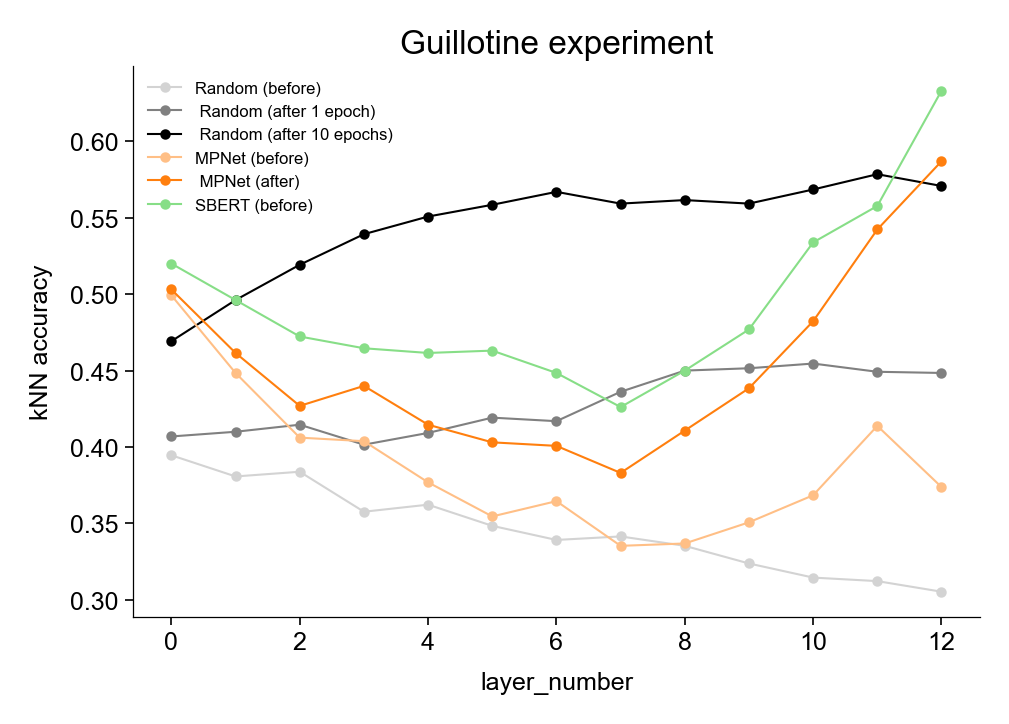

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")


knn_acc_after_all_mpnet = []
knn_acc_before_all_mpnet = []
knn_acc_before_all_sbert = []
knn_acc_before_all_random = []
knn_acc_after_all_random = []
knn_acc_after_10_all_random = []
for layer_number in np.arange(13):
    # load MPNet
    model_name = "MPNet"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after_mpnet = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before_mpnet = np.load(
        variables_path / saving_path / saving_name,
    )
    # load SBERT
    model_name = "SBERT"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before_sbert = np.load(
        variables_path / saving_path / saving_name,
    )

    # load random BERT
    model_name = "random_bert"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    saving_name = (
        f"knn_accuracies_untrained_av_after_layer_{layer_number}_v1.npy"
    )
    knn_acc_before_random = np.load(
        variables_path / saving_path / saving_name,
    )

    saving_name = (
        f"knn_accuracies_trained_n_epochs_1_av_after_layer_{layer_number}.npy"
    )
    knn_acc_after_random = np.load(
        variables_path / saving_path / saving_name,
    )

    saving_name = (
        f"knn_accuracies_trained_n_epochs_10_av_after_layer_{layer_number}.npy"
    )
    knn_acc_after_10_random = np.load(
        variables_path / saving_path / saving_name,
    )

    # concatenate
    knn_acc_after_all_mpnet.append(knn_acc_after_mpnet[0])
    knn_acc_before_all_mpnet.append(knn_acc_before_mpnet[0])
    knn_acc_before_all_sbert.append(knn_acc_before_sbert[0])
    knn_acc_before_all_random.append(knn_acc_before_random[0])
    knn_acc_after_all_random.append(knn_acc_after_random[0])
    knn_acc_after_10_all_random.append(knn_acc_after_10_random[0])

ax.plot(
    np.arange(13),
    knn_acc_before_all_random,
    c="lightgrey",
    ms=3,
    marker=".",
    label="Random (before)",
)
ax.plot(
    np.arange(13),
    knn_acc_after_all_random,
    c="grey",
    ms=3,
    marker=".",
    label=" Random (after 1 epoch)",
)
ax.plot(
    np.arange(13),
    knn_acc_after_10_all_random,
    c="k",
    ms=3,
    marker=".",
    label=" Random (after 10 epochs)",
)
ax.plot(
    np.arange(13),
    knn_acc_before_all_mpnet,
    c=tab10_colors_light["tab:orange"],
    ms=3,
    marker=".",
    label="MPNet (before)",
)
ax.plot(
    np.arange(13),
    knn_acc_after_all_mpnet,
    c=tab10_colors["tab:orange"],
    ms=3,
    marker=".",
    label=" MPNet (after)",
)

ax.plot(
    np.arange(13),
    knn_acc_before_all_sbert,
    c=tab10_colors_light["tab:green"],
    ms=3,
    marker=".",
    label="SBERT (before)",
)


ax.legend(fontsize=4)

ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
fig.savefig(figures_path / "guillotine_experiment_several_models_v3.png")

# Supplementary figures

## Fig embedding with labels

In [ ]:
# labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr_2.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color_2.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

In [71]:
5 / 6.75

0.7407407407407407

In [74]:
3 * 6.75 / 5

4.05

/gpfs01/berens/user/rgonzalesmarquez/phd/text-embeddings/text_embeddings_src/plotting.py:335: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot([x[i],center_cluster_coordinates_left.x[i]],[y[i],center_cluster_coordinates_left.y[i]], c=colr, linewidth=0.4, clip_on=False)
/gpfs01/berens/user/rgonzalesmarquez/phd/text-embeddings/text_embeddings_src/plotting.py:351: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot([x[i],center_cluster_coordinates_right.x[i]],[y[i],center_cluster_coordinates_right.y[i]], c=colr, linewidth=0.4, clip_on=False)


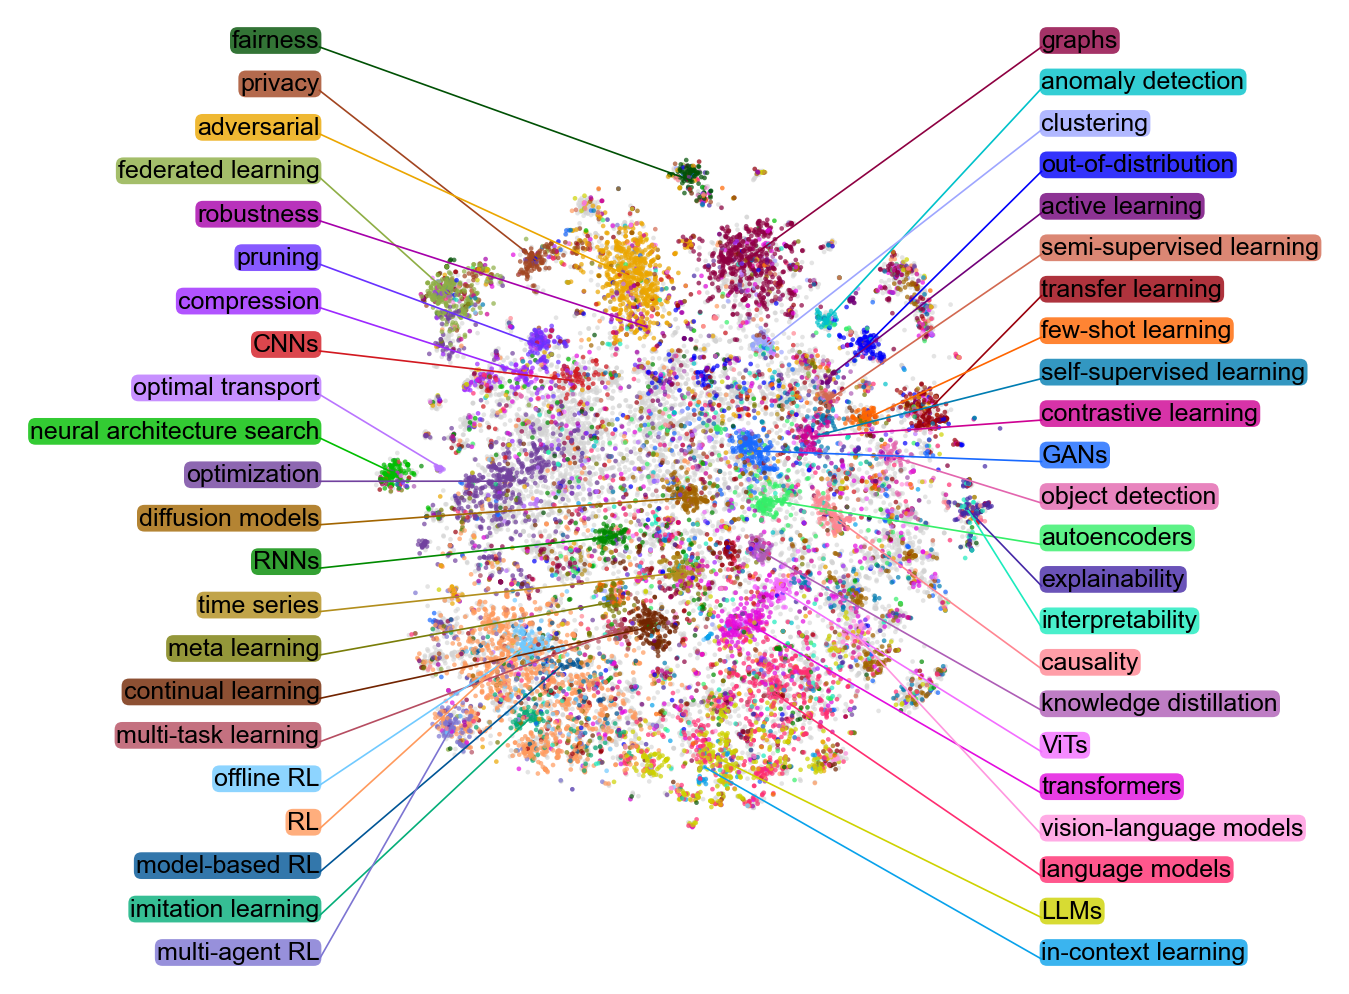

In [80]:
fig, ax = plt.subplots(figsize=(5, 3.2), dpi=300, layout="constrained")
xlim = (-95, 95)
ylim = (-95, 95)

model_name = "MPNet"
# load
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
tsne_av_after = np.load(
    variables_path
    / saving_path
    / "tsne_abstracts_only_av_after_training_av_1_epoch.npy",
)
plot_tsne_colors(tsne_av_after, colors_iclr, ax=ax, x_lim=xlim, y_lim=ylim)
plot_label_tags(
    tsne_av_after,
    colors_iclr,
    dict_label_to_color,
    x_lim=xlim,
    y_lim=(-120, 120),
    ax=ax,
    subset=False,
    fontsize=6,
    capitalize=False,
    middle_value=5,
)

fig.savefig(figures_path / "tsne_iclr_mpnet_with_tags_v4.png")
fig.savefig(figures_path / "tsne_iclr_mpnet_with_tags_v4.pdf")

## Fig some embeddings

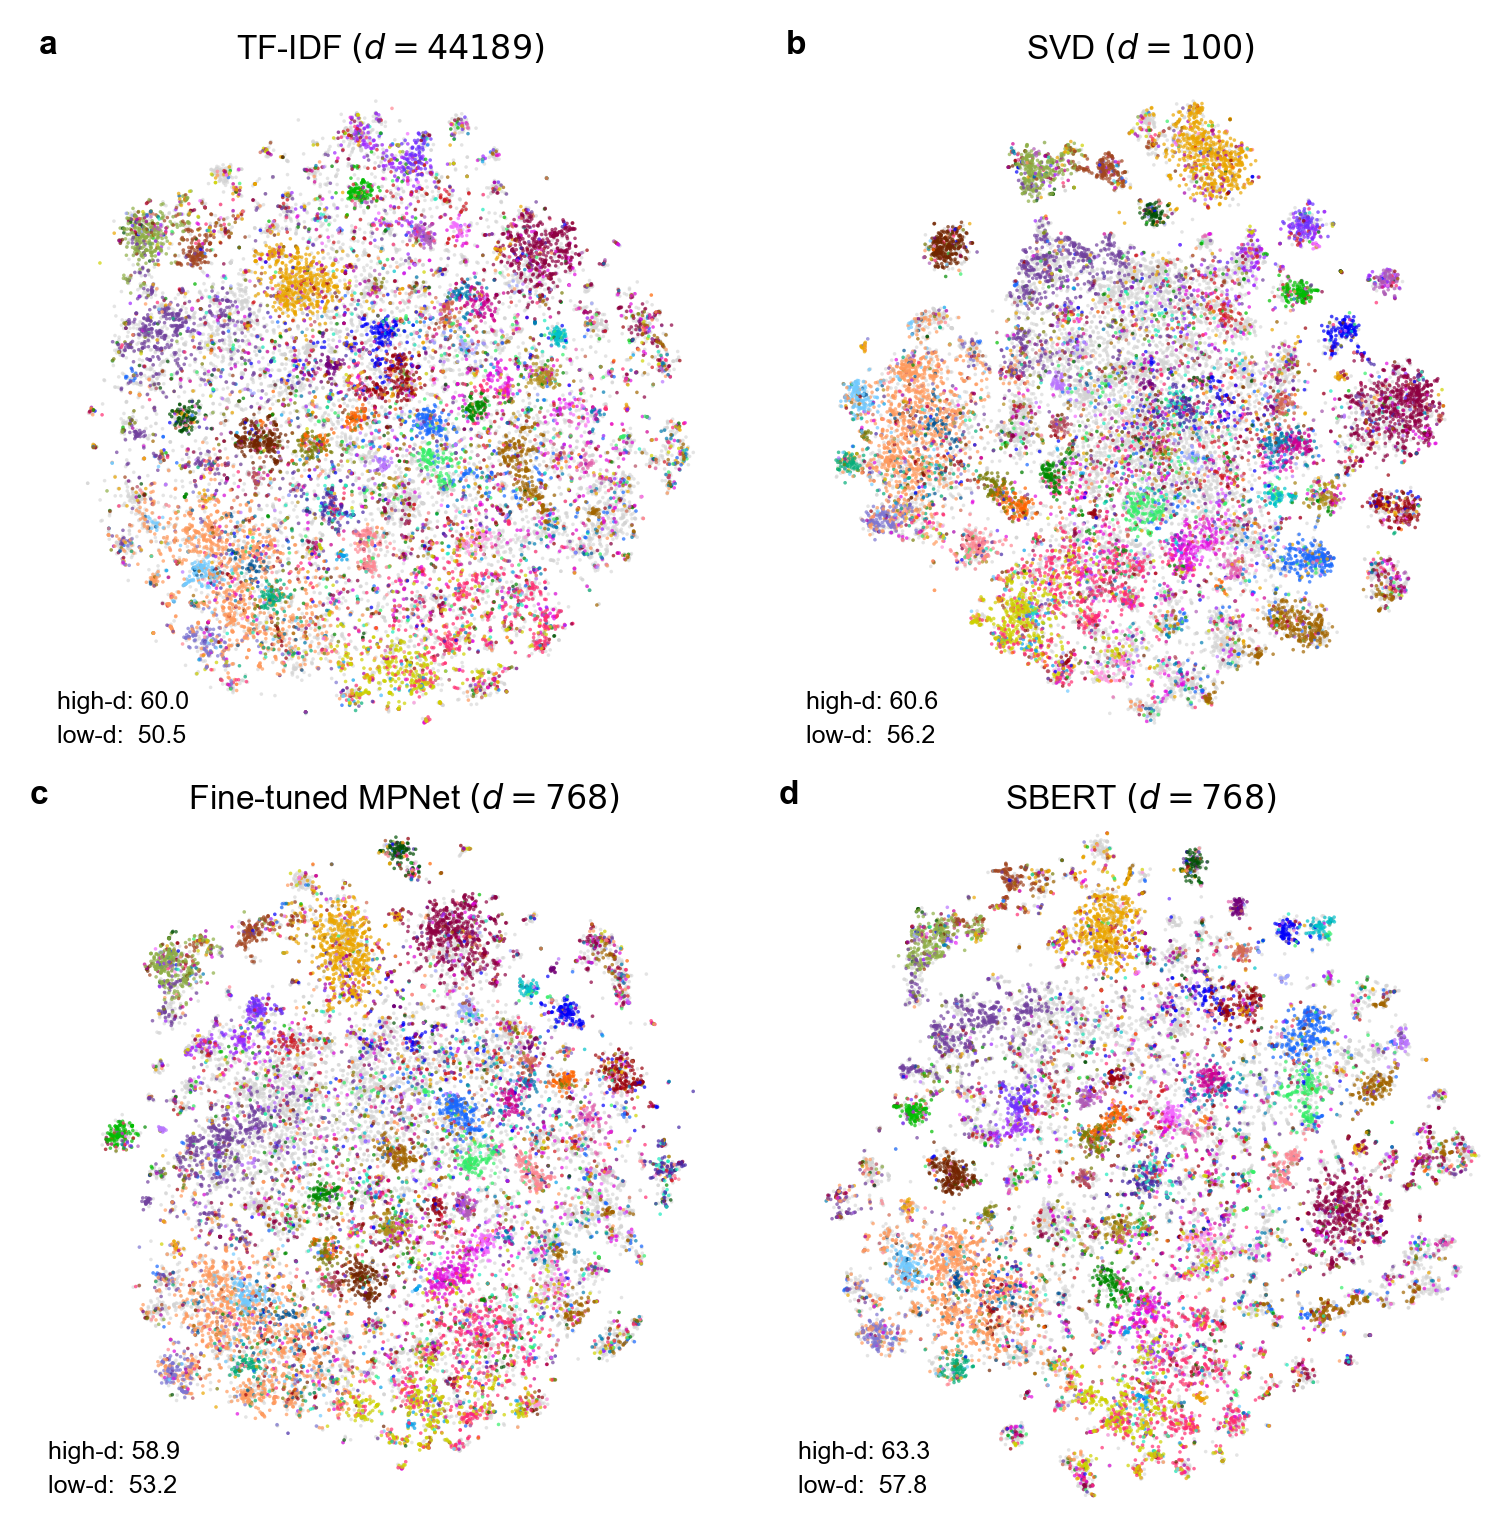

In [177]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5), dpi=300, layout="constrained")

txtkwargs = dict(size=8, weight="bold", va="top", ha="right")
title_size = 8  # 10
acc_fnt = 6  # 8
# load for (a) and (b)
## tsnes
tsne_tfidf = np.load(variables_path / "updated_dataset" / "tsne_tfidf.npy")
tsne_svd = np.load(variables_path / "updated_dataset" / "tsne_svd.npy")

## accuracies
knn_accuracy_tfidf = np.load(
    variables_path / "updated_dataset" / "knn_accuracy_tfidf.npy"
)
knn_accuracy_svd = np.load(
    variables_path / "updated_dataset" / "knn_accuracy_svd.npy"
)


knn_accuracy_tsne_tfidf = np.load(
    variables_path / "updated_dataset" / "knn_accuracy_tsne_tfidf.npy"
)
knn_accuracy_tsne_svd = np.load(
    variables_path / "updated_dataset" / "knn_accuracy_tsne_svd.npy"
)

## (a)
plot_tsne_colors(
    np.vstack((-tsne_tfidf[:, 1], tsne_tfidf[:, 0])).T,
    colors_iclr,
    ax=axs[0, 0],
    plot_type="subplot_3",
)
axs[0, 0].set_title(f"TF-IDF $(d=44189)$", fontsize=title_size)

axs[0, 0].text(
    0,
    0.06,
    f"high-d: {knn_accuracy_tfidf*100:.1f}",
    transform=axs[0, 0].transAxes,
    va="bottom",
    ha="left",
    size=acc_fnt,
)
axs[0, 0].text(
    0,
    0.01,
    f"low-d:  {knn_accuracy_tsne_tfidf*100:.1f}",
    transform=axs[0, 0].transAxes,
    va="bottom",
    ha="left",
    size=acc_fnt,
)
axs[0, 0].text(
    0,
    1.06,
    string.ascii_lowercase[0],
    transform=axs[0, 0].transAxes,
    **txtkwargs,
)


## (b)
plot_tsne_colors(
    np.vstack((-tsne_svd[:, 1], -tsne_svd[:, 0])).T,
    colors_iclr,
    ax=axs[0, 1],
    plot_type="subplot_3",
)
axs[0, 1].set_title("SVD $(d=100)$", fontsize=title_size)
axs[0, 1].text(
    0,
    0.06,
    f"high-d: {knn_accuracy_svd*100:.1f}",
    transform=axs[0, 1].transAxes,
    va="bottom",
    ha="left",
    size=acc_fnt,
)
axs[0, 1].text(
    0,
    0.01,
    f"low-d:  {knn_accuracy_tsne_svd*100:.1f}",
    transform=axs[0, 1].transAxes,
    va="bottom",
    ha="left",
    size=acc_fnt,
)
axs[0, 1].text(
    0,
    1.06,
    string.ascii_lowercase[1],
    transform=axs[0, 1].transAxes,
    **txtkwargs,
)


## (c)
# load
xlim = (-95, 95)
ylim = (-95, 95)
saving_path = Path("embeddings_mpnet") / Path("updated_dataset")
tsne_av_after = np.load(
    variables_path
    / saving_path
    / "tsne_abstracts_only_av_after_training_av_1_epoch.npy",
)
plot_tsne_colors(
    tsne_av_after,
    colors_iclr,
    ax=axs[1, 0],
    x_lim=xlim,
    y_lim=ylim,
    plot_type="subplot_3",
)
axs[1, 0].text(
    0,
    0.06,
    f"high-d: 58.9",
    transform=axs[1, 0].transAxes,
    va="bottom",
    ha="left",
    size=acc_fnt,
)
axs[1, 0].text(
    0,
    0.01,
    f"low-d:  53.2",
    transform=axs[1, 0].transAxes,
    va="bottom",
    ha="left",
    size=acc_fnt,
)


axs[1, 0].set_title(f"   Fine-tuned MPNet $(d=768)$", fontsize=title_size)
axs[1, 0].text(
    0,
    1.06,
    string.ascii_lowercase[2],
    transform=axs[1, 0].transAxes,
    **txtkwargs,
)


## (d)
xlim = (-95, 95)
ylim = (-95, 95)
# load
## tsnes
saving_path = Path("embeddings_sbert") / Path("updated_dataset")
tsne_name = "tsne_av.npy"
tsne_av_sbert = np.load(variables_path / saving_path / tsne_name)
## accuracies
saving_name = Path("knn_accuracy_sbert.npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name)

saving_name = Path("knn_accuracy_tsne_sbert.npy")
knn_acc_lowd = np.load(variables_path / "updated_dataset" / saving_name)

plot_tsne_colors(
    np.vstack((-tsne_av_sbert[:, 1], tsne_av_sbert[:, 0])).T,
    colors_iclr,
    ax=axs[1, 1],
    x_lim=xlim,
    y_lim=ylim,
    plot_type="subplot_3",
)
axs[1, 1].text(
    0,
    0.06,
    f"high-d: {knn_acc_highd[0]*100:.1f}",
    transform=axs[1, 1].transAxes,
    va="bottom",
    ha="left",
    size=acc_fnt,
)
axs[1, 1].text(
    0,
    0.01,
    f"low-d:  {knn_acc_lowd[0]*100:.1f}",
    transform=axs[1, 1].transAxes,
    va="bottom",
    ha="left",
    size=acc_fnt,
)

axs[1, 1].set_title(f"SBERT $(d=768)$", fontsize=title_size)
axs[1, 1].text(
    0,
    1.06,
    string.ascii_lowercase[3],
    transform=axs[1, 1].transAxes,
    **txtkwargs,
)

fig.savefig(figures_path / "supplementary_figure_tsne_embeddings_v5.png")
fig.savefig(figures_path / "supplementary_figure_tsne_embeddings_v5.pdf")

## Random BERT

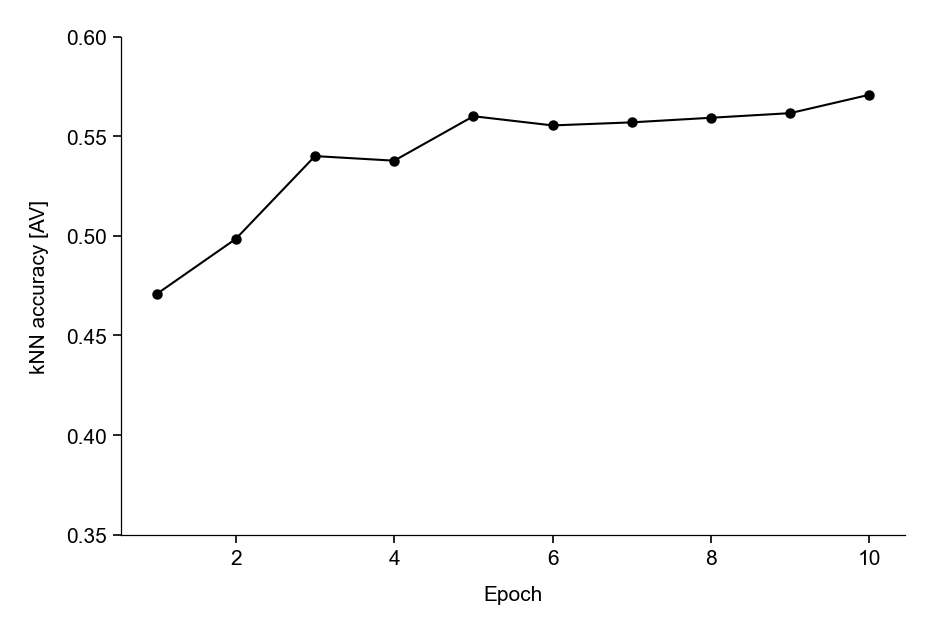

In [137]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 2), dpi=300, layout="constrained")

colormap = plt.get_cmap("tab10")
rep = 0  # av
model_name = "random_bert"

# for i, model_name in enumerate(model_names):
# load things
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

losses = np.load(variables_path / saving_path / "losses_run1.npy")
knn_accuracies_after = np.load(
    variables_path / saving_path / "knn_accuracies_run1.npy"
)

saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_accuracies_before = np.load(
    variables_path / "updated_dataset" / saving_name_2
)

ax.plot(
    np.arange(10) + 1,
    knn_accuracies_after[:, rep],
    # label=f"{model_name}",
    color="k",
    marker=".",
    ms=3,
)

# ax.set_xticks(np.arange(len(model_names)))
# ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylim(0.35, 0.6)
ax.set_ylabel("kNN accuracy [AV]")
ax.set_xlabel("Epoch")
# ax.set_xlim(0.35, 0.6)
# ax.legend(loc="lower right")
# ax.set_title("[AV]")


fig.savefig(
    figures_path / "knn_accuracy_training_run1_with_random_bert_v1.png"
)

In [1]:
knn_accuracies_after.shape

NameError: name 'knn_accuracies_after' is not defined

## Guillotine other datasets

In [56]:
5.5 / 3 * 2.3 / 3.25

1.2974358974358973

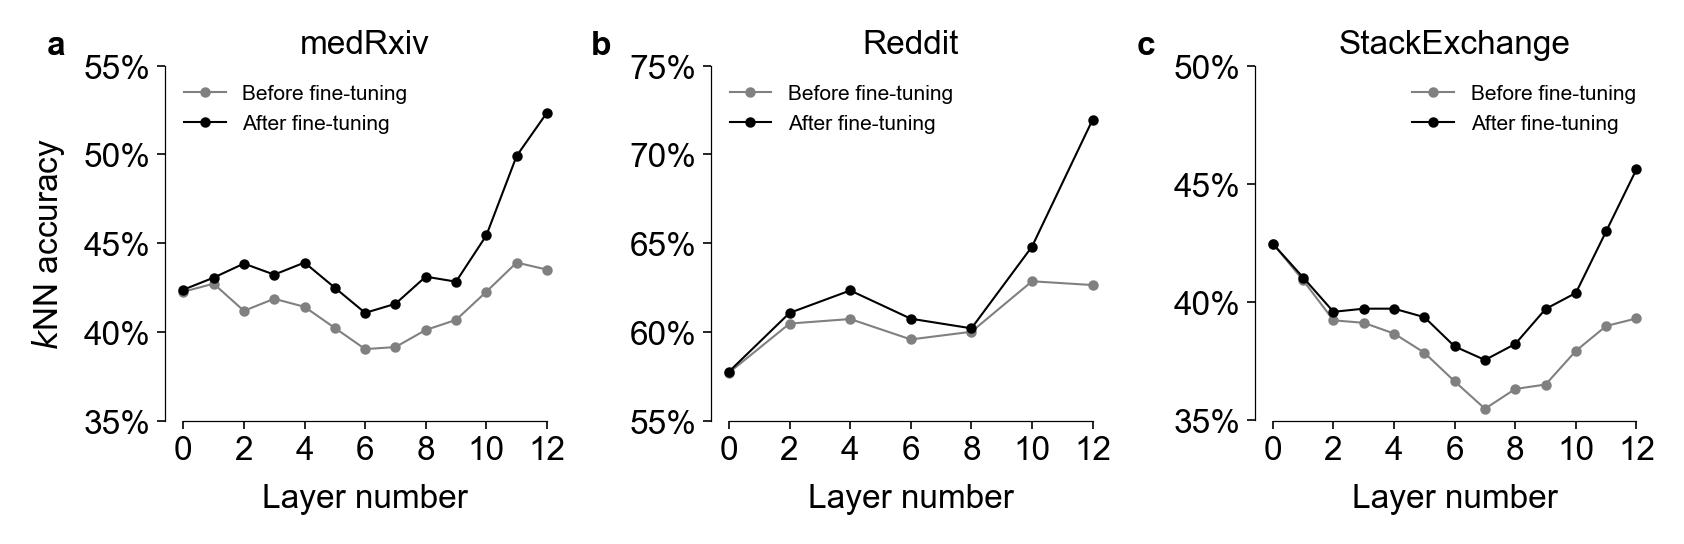

In [77]:
%matplotlib inline
fig, axs = plt.subplots(
    1, 3, figsize=(5.5, 1.7), dpi=300, layout="constrained"
)
txtkwargs = dict(size=8, weight="bold", va="top", ha="right")

model_name = "MPNet"

# a) MEDRXIV
dataset_name = "medrxiv"
knn_acc_after_all = []
knn_acc_before_all = []
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_after_all.append(knn_acc_after[0])
    knn_acc_before_all.append(knn_acc_before[0])

axs[0].plot(
    np.arange(13),
    knn_acc_before_all,
    c="grey",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)

axs[0].plot(
    np.arange(13),
    knn_acc_after_all,
    c="k",
    ms=3,
    marker=".",
    label="After fine-tuning",
)

axs[0].legend()
axs[0].set_xlabel("Layer number")
axs[0].set_ylabel("$k$NN accuracy")
axs[0].set_title("medRxiv")
axs[0].text(
    -0.25,
    1.1,
    string.ascii_lowercase[0],
    transform=axs[0].transAxes,
    **txtkwargs,
)
axs[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs[0].set_yticks(np.arange(0.35, 0.6, 0.05))
axs[0].spines.left.set_bounds(0.35, 0.55)
axs[0].set_xticks(np.arange(0, 14, 2))
axs[0].spines.bottom.set_bounds(
    0,
    12,
)


# b) REDDIT
dataset_name = "reddit"
knn_acc_after_all = []
knn_acc_before_all = []
for layer_number in np.arange(7) * 2:
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )

    saving_name = (
        f"knn_accuracies_trained_av_after_layer_{layer_number}_v2.npy"
    )
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = (
        f"knn_accuracies_untrained_av_after_layer_{layer_number}_v2.npy"
    )
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_after_all.append(knn_acc_after[0])
    knn_acc_before_all.append(knn_acc_before[0])

axs[1].plot(
    np.arange(7) * 2,
    knn_acc_before_all,
    c="grey",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)

axs[1].plot(
    np.arange(7) * 2,
    knn_acc_after_all,
    c="k",
    ms=3,
    marker=".",
    label="After fine-tuning",
)

axs[1].legend()
axs[1].set_xlabel("Layer number")
# axs[1].set_ylabel("kNN accuracy")
axs[1].set_title("Reddit")
axs[1].text(
    -0.25,
    1.1,
    string.ascii_lowercase[1],
    transform=axs[1].transAxes,
    **txtkwargs,
)
axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs[1].set_yticks(np.arange(0.55, 0.8, 0.05))
axs[1].spines.left.set_bounds(0.55, 0.75)
axs[1].set_xticks(np.arange(0, 14, 2))
axs[1].spines.bottom.set_bounds(
    0,
    12,
)

# c) STACKEXCHANGE
dataset_name = "stackexchange"
knn_acc_after_all = []
knn_acc_before_all = []
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_after_all.append(knn_acc_after[0])
    knn_acc_before_all.append(knn_acc_before[0])

axs[2].plot(
    np.arange(13),
    knn_acc_before_all,
    c="grey",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)

axs[2].plot(
    np.arange(13),
    knn_acc_after_all,
    c="k",
    ms=3,
    marker=".",
    label="After fine-tuning",
)

axs[2].legend()
axs[2].set_xlabel("Layer number")
# axs[2].set_ylabel("kNN accuracy")
axs[2].set_yticks([0.35, 0.40, 0.45])
axs[2].set_title("StackExchange")
axs[2].text(
    -0.25,
    1.1,
    string.ascii_lowercase[2],
    transform=axs[2].transAxes,
    **txtkwargs,
)
axs[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs[2].set_yticks(np.arange(0.35, 0.5, 0.05))
axs[2].spines.left.set_bounds(0.35, 0.5)
axs[2].set_xticks(np.arange(0, 14, 2))
axs[2].spines.bottom.set_bounds(
    0,
    12,
)

fig.savefig(figures_path / "guillotine_other_datasets_v2.png")
fig.savefig(figures_path / "guillotine_other_datasets_v2.pdf")

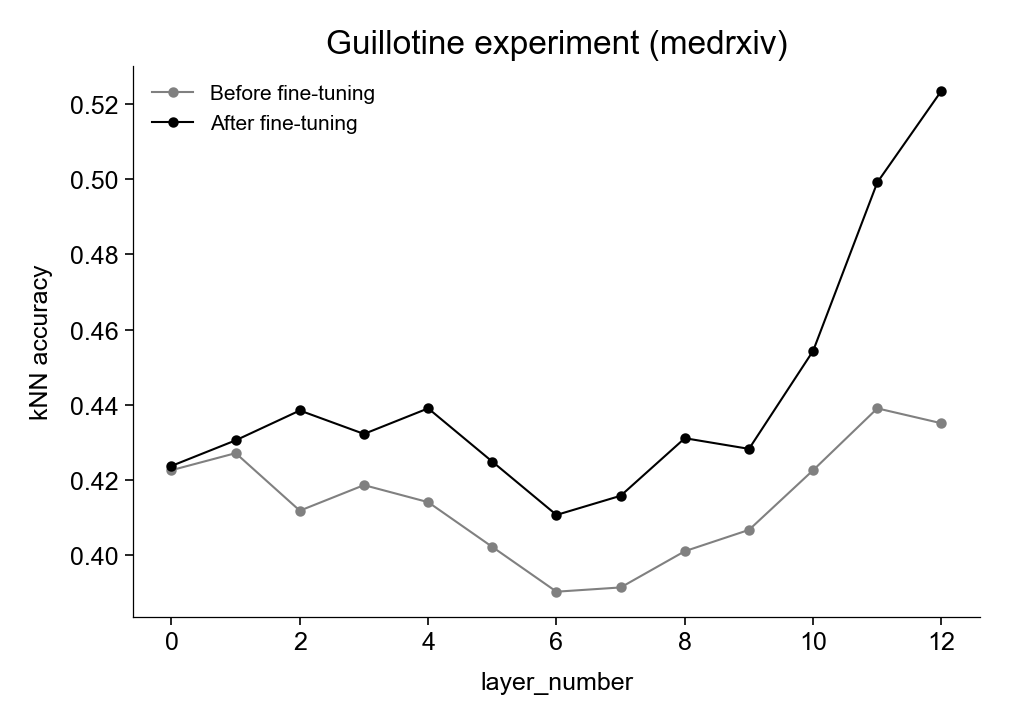

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
knn_acc_after_all = []
knn_acc_before_all = []
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )

    # saving_name = (
    #     f"knn_accuracies_trained_simcse_av_after_layer_{layer_number}.npy"
    # )
    # knn_acc_after_simcse = np.load(
    #     variables_path / saving_path / saving_name,
    # )

    knn_acc_after_all.append(knn_acc_after[0])
    knn_acc_before_all.append(knn_acc_before[0])
    # knn_acc_after_simcse_all.append(knn_acc_after_simcse[0])

ax.plot(
    np.arange(13),
    knn_acc_before_all,
    c="grey",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)

ax.plot(
    np.arange(13),
    knn_acc_after_all,
    c="k",
    ms=3,
    marker=".",
    label="After fine-tuning",
)

# ax.plot(
#     np.arange(13),
#     knn_acc_after_simcse_all,
#     c="darkred",
#     ms=3,
#     marker=".",
#     label="After SimCSE-like fine-tuning",
# )
ax.legend()
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title(f"Guillotine experiment ({dataset_name})")
fig.savefig(figures_path / f"guillotine_experiment_mpnet_{dataset_name}.png")

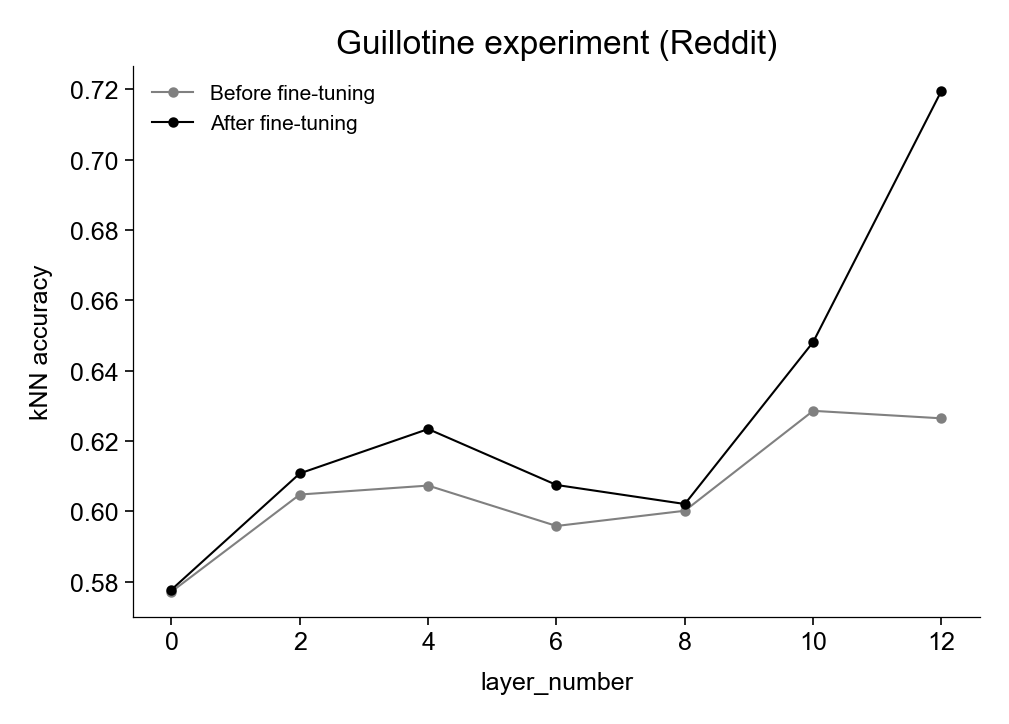

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
knn_acc_after_all = []
knn_acc_before_all = []
# knn_acc_after_simcse_all = []
for layer_number in np.arange(7) * 2:
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path("mteb_datasets/reddit")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = (
        f"knn_accuracies_trained_av_after_layer_{layer_number}_v2.npy"
    )
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = (
        f"knn_accuracies_untrained_av_after_layer_{layer_number}_v2.npy"
    )
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )

    # saving_name = (
    #     f"knn_accuracies_trained_simcse_av_after_layer_{layer_number}.npy"
    # )
    # knn_acc_after_simcse = np.load(
    #     variables_path / saving_path / saving_name,
    # )

    knn_acc_after_all.append(knn_acc_after[0])
    knn_acc_before_all.append(knn_acc_before[0])
    # knn_acc_after_simcse_all.append(knn_acc_after_simcse[0])

ax.plot(
    np.arange(7) * 2,
    knn_acc_before_all,
    c="grey",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)

ax.plot(
    np.arange(7) * 2,
    knn_acc_after_all,
    c="k",
    ms=3,
    marker=".",
    label="After fine-tuning",
)

# ax.plot(
#     np.arange(13),
#     knn_acc_after_simcse_all,
#     c="darkred",
#     ms=3,
#     marker=".",
#     label="After SimCSE-like fine-tuning",
# )
ax.legend()
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment (Reddit)")
fig.savefig(figures_path / "guillotine_experiment_mpnet_reddit_v2.png")

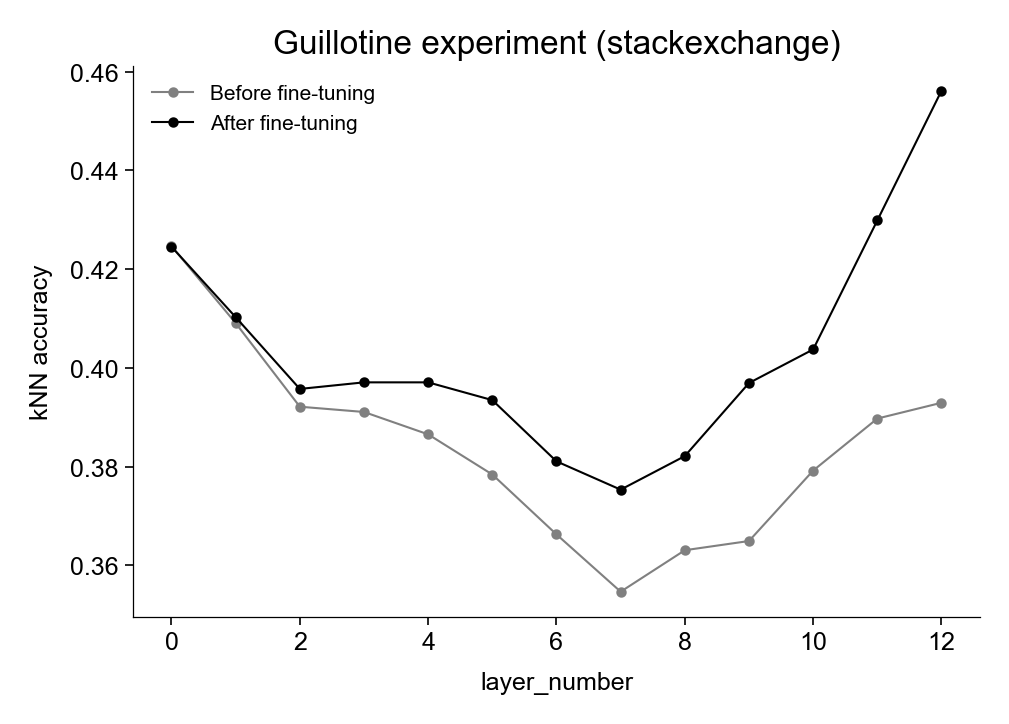

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
knn_acc_after_all = []
knn_acc_before_all = []
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )

    # saving_name = (
    #     f"knn_accuracies_trained_simcse_av_after_layer_{layer_number}.npy"
    # )
    # knn_acc_after_simcse = np.load(
    #     variables_path / saving_path / saving_name,
    # )

    knn_acc_after_all.append(knn_acc_after[0])
    knn_acc_before_all.append(knn_acc_before[0])
    # knn_acc_after_simcse_all.append(knn_acc_after_simcse[0])

ax.plot(
    np.arange(13),
    knn_acc_before_all,
    c="grey",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)

ax.plot(
    np.arange(13),
    knn_acc_after_all,
    c="k",
    ms=3,
    marker=".",
    label="After fine-tuning",
)

# ax.plot(
#     np.arange(13),
#     knn_acc_after_simcse_all,
#     c="darkred",
#     ms=3,
#     marker=".",
#     label="After SimCSE-like fine-tuning",
# )
ax.legend()
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title(f"Guillotine experiment ({dataset_name})")
fig.savefig(figures_path / f"guillotine_experiment_mpnet_{dataset_name}.png")